In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import itertools
import pickle


from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import ComplementNB
from sklearn.preprocessing import MinMaxScaler
from sklearn import svm, tree
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import mean_absolute_error, accuracy_score, confusion_matrix, classification_report, plot_confusion_matrix


import tensorflow as tf

In [2]:
train_dataset_path = "../input/nslkdd/KDDTrain+.txt"
test_dataset_plus = "../input/nslkdd/KDDTest+.txt"

train = pd.read_csv(train_dataset_path, header = None)
test_plus = pd.read_csv(test_dataset_plus, header = None)

In [3]:
columns = (['duration'
,'protocol_type'
,'service'
,'flag'
,'src_bytes'
,'dst_bytes'
,'land'
,'wrong_fragment'
,'urgent'
,'hot'
,'num_failed_logins'
,'logged_in'
,'num_compromised'
,'root_shell'
,'su_attempted'
,'num_root'
,'num_file_creations'
,'num_shells'
,'num_access_files'
,'num_outbound_cmds'
,'is_host_login'
,'is_guest_login'
,'count'
,'srv_count'
,'serror_rate'
,'srv_serror_rate'
,'rerror_rate'
,'srv_rerror_rate'
,'same_srv_rate'
,'diff_srv_rate'
,'srv_diff_host_rate'
,'dst_host_count'
,'dst_host_srv_count'
,'dst_host_same_srv_rate'
,'dst_host_diff_srv_rate'
,'dst_host_same_src_port_rate'
,'dst_host_srv_diff_host_rate'
,'dst_host_serror_rate'
,'dst_host_srv_serror_rate'
,'dst_host_rerror_rate'
,'dst_host_srv_rerror_rate'
,'attack'
,'level'])

In [4]:
train.columns = columns
test_plus.columns = columns

In [5]:
df = train
test_df = test_plus

In [6]:
df.shape, test_df.shape

((125973, 43), (22544, 43))

In [7]:
df.dropna()
test_df.dropna()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,attack,level
0,0,tcp,private,REJ,0,0,0,0,0,0,...,0.04,0.06,0.00,0.00,0.00,0.0,1.00,1.00,neptune,21
1,0,tcp,private,REJ,0,0,0,0,0,0,...,0.00,0.06,0.00,0.00,0.00,0.0,1.00,1.00,neptune,21
2,2,tcp,ftp_data,SF,12983,0,0,0,0,0,...,0.61,0.04,0.61,0.02,0.00,0.0,0.00,0.00,normal,21
3,0,icmp,eco_i,SF,20,0,0,0,0,0,...,1.00,0.00,1.00,0.28,0.00,0.0,0.00,0.00,saint,15
4,1,tcp,telnet,RSTO,0,15,0,0,0,0,...,0.31,0.17,0.03,0.02,0.00,0.0,0.83,0.71,mscan,11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22539,0,tcp,smtp,SF,794,333,0,0,0,0,...,0.72,0.06,0.01,0.01,0.01,0.0,0.00,0.00,normal,21
22540,0,tcp,http,SF,317,938,0,0,0,0,...,1.00,0.00,0.01,0.01,0.01,0.0,0.00,0.00,normal,21
22541,0,tcp,http,SF,54540,8314,0,0,0,2,...,1.00,0.00,0.00,0.00,0.00,0.0,0.07,0.07,back,15
22542,0,udp,domain_u,SF,42,42,0,0,0,0,...,0.99,0.01,0.00,0.00,0.00,0.0,0.00,0.00,normal,21


In [8]:
df.shape, test_df.shape

((125973, 43), (22544, 43))

In [9]:
dos_attacks = [
    'apache2', 'back', 'land', 'mailbomb', 'neptune', 'pod' ,'smurf', 'teardrop', 'worm', 'processtable', 'udpstorm'
]

probe_attacks = [
    'ipsweep', 'mscan', 'nmap', 'portsweep', 'saint', 'satan'
]

r2l_attacks = [
    'ftp_write', 'guess_passwd' ,'httptunnel', 'imap', 'multihop', 'named', 'phf', 'sendmail' ,'snmpgetattack', 'snmpguess', 'xlock', 'warezmaster', 
    'xsnoop', 'warezclient', 'spy'
]

u2r_attacks = [
    'buffer_overflow' ,'ps', 'perl', 'loadmodule', 'sqlattack', 'xterm', 'rootkit'
]


normal_attacks = [
    'normal'
]

In [10]:
# Normal -> 0
# DoS -> 1
# Probe -> 2
# R2L -> 3
# U2R -> 4

def map_attack(attack):
    if attack in dos_attacks:
        attack_type = 1
        
    elif attack in probe_attacks:
        attack_type = 2
        
    elif attack in r2l_attacks:
        attack_type = 3
        
    elif attack in u2r_attacks:
        attack_type = 4
        
    else:
        attack_type = 0
        
    return attack_type

In [11]:
attack_map = df.attack.apply(map_attack)
df['attack_map'] = attack_map

test_attack_map = test_df.attack.apply(map_attack)
test_df['attack_map'] = test_attack_map

In [12]:
df.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,attack,level,attack_map
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,...,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal,20,0
1,0,udp,other,SF,146,0,0,0,0,0,...,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal,15,0
2,0,tcp,private,S0,0,0,0,0,0,0,...,0.05,0.00,0.00,1.00,1.00,0.00,0.00,neptune,19,1
3,0,tcp,http,SF,232,8153,0,0,0,0,...,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal,21,0
4,0,tcp,http,SF,199,420,0,0,0,0,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal,21,0


In [13]:
attack_vs_protocol = pd.crosstab(df.attack, df.protocol_type)
attack_vs_protocol

protocol_type,icmp,tcp,udp
attack,,,
back,0,956,0
buffer_overflow,0,30,0
ftp_write,0,8,0
guess_passwd,0,53,0
imap,0,11,0
ipsweep,3117,482,0
land,0,18,0
loadmodule,0,9,0
multihop,0,7,0


In [14]:
attack_vs_protocol2 = pd.crosstab(test_df.attack, test_df.protocol_type)
attack_vs_protocol2

protocol_type,icmp,tcp,udp
attack,,,
apache2,0,737,0
back,0,359,0
buffer_overflow,0,20,0
ftp_write,0,3,0
guess_passwd,0,1231,0
httptunnel,0,133,0
imap,0,1,0
ipsweep,141,0,0
land,0,7,0


In [15]:
def bake_pies(data_list,labels):
    list_length = len(data_list)
    
    # setup for mapping colors
    color_list = sns.color_palette()
    color_cycle = itertools.cycle(color_list)
    cdict = {}
    
    # build the subplots
    fig, axs = plt.subplots(1, list_length,figsize=(18,10), tight_layout=False)
    plt.subplots_adjust(wspace=1/list_length)
    
    # loop through the data sets and build the charts
    for count, data_set in enumerate(data_list): 
        
        # update our color mapt with new values
        for num, value in enumerate(np.unique(data_set.index)):
            if value not in cdict:
                cdict[value] = next(color_cycle)
       
        # build the wedges
        wedges,texts = axs[count].pie(data_set,
                           colors=[cdict[v] for v in data_set.index])

        # build the legend
        axs[count].legend(wedges, data_set.index,
                           title="Flags",
                           loc="center left",
                           bbox_to_anchor=(1, 0, 0.5, 1))
        # set the title
        axs[count].set_title(labels[count])
        
    return axs   

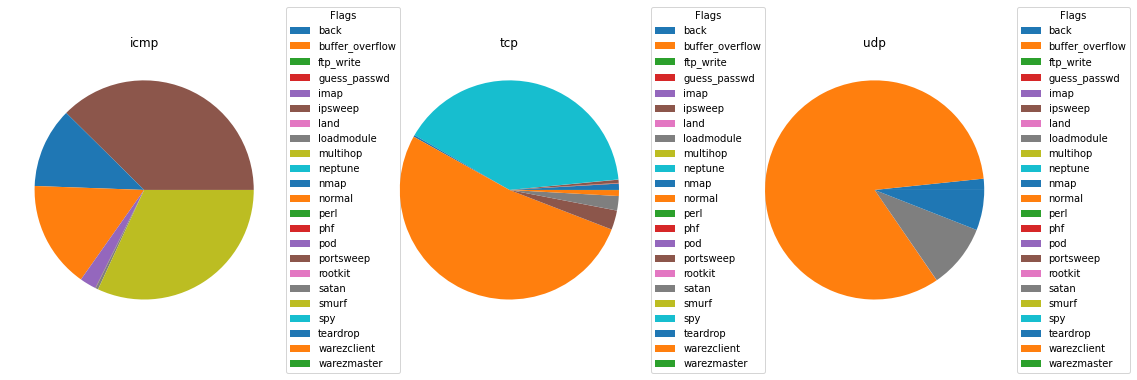

In [16]:
icmp_attacks = attack_vs_protocol.icmp
tcp_attacks = attack_vs_protocol.tcp
udp_attacks = attack_vs_protocol.udp

# create the charts
bake_pies([icmp_attacks, tcp_attacks, udp_attacks],['icmp','tcp','udp'])
plt.savefig('bakepies.png')
plt.show()

In [17]:
df.dtypes

duration                         int64
protocol_type                   object
service                         object
flag                            object
src_bytes                        int64
dst_bytes                        int64
land                             int64
wrong_fragment                   int64
urgent                           int64
hot                              int64
num_failed_logins                int64
logged_in                        int64
num_compromised                  int64
root_shell                       int64
su_attempted                     int64
num_root                         int64
num_file_creations               int64
num_shells                       int64
num_access_files                 int64
num_outbound_cmds                int64
is_host_login                    int64
is_guest_login                   int64
count                            int64
srv_count                        int64
serror_rate                    float64
srv_serror_rate          

In [18]:
# Normal -> 0
# DoS -> 1
# Probe -> 2
# R2L -> 3
# U2R -> 4

df['attack_map'].value_counts()

0    67343
1    45927
2    11656
3      995
4       52
Name: attack_map, dtype: int64

In [19]:
objects = list(df.select_dtypes(['object']).columns)
integers = list(df.select_dtypes(['int64']).columns)
floats = list(df.select_dtypes(['float64']).columns)

In [20]:
objects.remove('attack')
integers.remove('attack_map')
integers.remove('level')

In [21]:
features_to_encode = objects
numeric_features = integers + floats

encoded_train = pd.get_dummies(df[features_to_encode])
encoded_test = pd.get_dummies(test_df[features_to_encode])

In [22]:
## Nel test set non sono presenti tutte le features, quindi bisogna prendere le differenze

test_index = np.arange(len(test_df.index))
column_diffs = list(set(encoded_train.columns.values)-set(encoded_test.columns.values))
diff_df = pd.DataFrame(0, index=test_index, columns=column_diffs)

## Riordino le colonne in modo da farle corrispondere
column_order = encoded_train.columns.to_list()

## Aggiungo le colonne
test_encoded_temp = encoded_test.join(diff_df)

## Riordino le colonne
test_final = test_encoded_temp[column_order].fillna(0)

In [23]:
training_set = encoded_train.join(df[numeric_features])
test_set = test_final.join(test_df[numeric_features])

In [24]:
training_set.head()

,protocol_type_icmp,protocol_type_tcp,protocol_type_udp,service_IRC,service_X11,service_Z39_50,service_aol,service_auth,service_bgp,service_courier,...,diff_srv_rate,srv_diff_host_rate,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate
0,0,1,0,0,0,0,0,0,0,0,...,0.00,0.00,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00
1,0,0,1,0,0,0,0,0,0,0,...,0.15,0.00,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00
2,0,1,0,0,0,0,0,0,0,0,...,0.07,0.00,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00
3,0,1,0,0,0,0,0,0,0,0,...,0.00,0.00,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01
4,0,1,0,0,0,0,0,0,0,0,...,0.00,0.09,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


In [25]:
training_set.shape

(125973, 122)

In [26]:
test_set.head()

,protocol_type_icmp,protocol_type_tcp,protocol_type_udp,service_IRC,service_X11,service_Z39_50,service_aol,service_auth,service_bgp,service_courier,...,diff_srv_rate,srv_diff_host_rate,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate
0,0,1,0,0,0,0,0,0,0,0,...,0.06,0.00,0.04,0.06,0.00,0.00,0.0,0.0,1.00,1.00
1,0,1,0,0,0,0,0,0,0,0,...,0.06,0.00,0.00,0.06,0.00,0.00,0.0,0.0,1.00,1.00
2,0,1,0,0,0,0,0,0,0,0,...,0.00,0.00,0.61,0.04,0.61,0.02,0.0,0.0,0.00,0.00
3,1,0,0,0,0,0,0,0,0,0,...,0.00,1.00,1.00,0.00,1.00,0.28,0.0,0.0,0.00,0.00
4,0,1,0,0,0,0,0,0,0,0,...,0.00,0.75,0.31,0.17,0.03,0.02,0.0,0.0,0.83,0.71


In [27]:
test_set.shape

(22544, 122)

In [28]:
## Min-Max Scaling

scaler = MinMaxScaler()
training_set = pd.DataFrame(scaler.fit_transform(training_set), columns=training_set.columns)
test_set = pd.DataFrame(scaler.fit_transform(test_set), columns=test_set.columns)

In [29]:
def split_dataset(training_set, test_set, df, test_df):
    X_train = np.array(training_set)
    X_test = np.array(test_set)
    y_train = np.array(df['attack_map'])
    y_test = np.array(test_df['attack_map'])
    return X_train, X_test, y_train, y_test


def get_accuracy_per_class(model_name, dataset_type, y_test,predictions, model_accuracy):
    report = classification_report(y_test, predictions, output_dict = True)
    keys = list(report.keys())
    values = list(report.values())
    classes = keys[:-3]
    accuracy_per_class = []
    for i in range(len(classes)):
        accuracy_per_class.append(values[i]['recall'])
    x = classes
    y = []
    for i in accuracy_per_class:
        y.append(round(i*100,2))
    acc_per_class = dict(zip(x,y))
    

    plt.figure(figsize = (6,6))
    plt.bar(x,y,align='center')
    plt.xlabel(f'''Classes
    Model Accuracy: {model_accuracy}''')
    plt.ylabel('Accuracy per class')
    plt.yticks([i for i in y])
    plt.title(f'{model_name} - {dataset_type}')
    plt.savefig(f'{model_name}_classes_accuracies_({dataset_type}).png')
    plt.show()
    return acc_per_class

In [30]:
X_train, X_test, y_train, y_test = split_dataset(training_set=training_set, test_set=test_set, df=df, test_df=test_df)


with open('X_train.pk','wb') as f:
    pickle.dump(X_train, f)
with open('X_test.pk','wb') as f:
    pickle.dump(X_test, f)
with open('y_train.pk','wb') as f:
    pickle.dump(y_train, f)
with open('y_test.pk','wb') as f:
    pickle.dump(y_test, f)

In [31]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((125973, 122), (22544, 122), (125973,), (22544,))

<h1> MACHINE LEARNING

Model: logistic_regression
Elapsed time: 4.112888371000054
----------------------------------------------------------------------------------

****** TEST ******
Accuracy: 0.7420156139105749


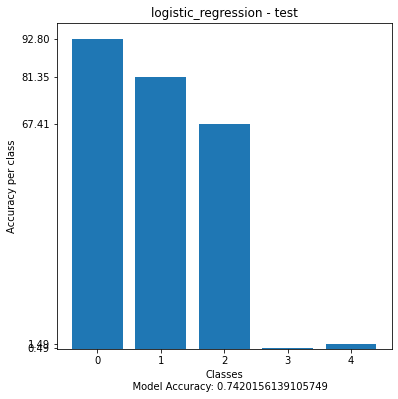

Accuracy per class: {'0': 92.8, '1': 81.35, '2': 67.41, '3': 0.49, '4': 1.49}
Confusion Matrix: 
 [[9.28019771e-01 9.06188858e-03 6.26094120e-02 2.05952013e-04
  1.02976007e-04]
 [1.84584450e-01 8.13538874e-01 1.87667560e-03 0.00000000e+00
  0.00000000e+00]
 [2.45353160e-01 6.89797604e-02 6.74101611e-01 1.15654688e-02
  0.00000000e+00]
 [9.92720971e-01 1.03986135e-03 1.38648180e-03 4.85268631e-03
  0.00000000e+00]
 [9.85074627e-01 0.00000000e+00 0.00000000e+00 0.00000000e+00
  1.49253731e-02]]
MAE Test: 0.5746096522356281


----------------------------------------------------------------------------------
----------------------------------------------------------------------------------
----------------------------------------------------------------------------------


Model: random-forest
Elapsed time: 11.036992743000042
----------------------------------------------------------------------------------

****** TEST ******
Accuracy: 0.7408623136976579


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


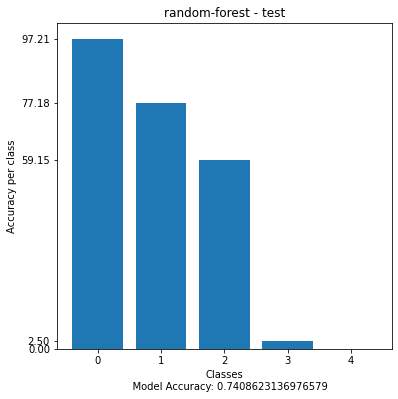

Accuracy per class: {'0': 97.21, '1': 77.18, '2': 59.15, '3': 2.5, '4': 0.0}
Confusion Matrix: 
 [[0.9720935  0.00864998 0.01925651 0.         0.        ]
 [0.22265416 0.77184987 0.00549598 0.         0.        ]
 [0.34118133 0.06732755 0.59149112 0.         0.        ]
 [0.97504333 0.         0.         0.02495667 0.        ]
 [0.94029851 0.         0.         0.05970149 0.        ]]
MAE Test: 0.5620120652945352


----------------------------------------------------------------------------------
----------------------------------------------------------------------------------
----------------------------------------------------------------------------------


Model: naive_bayes
Elapsed time: 0.08282514600000468
----------------------------------------------------------------------------------

****** TEST ******
Accuracy: 0.7083481192334989


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


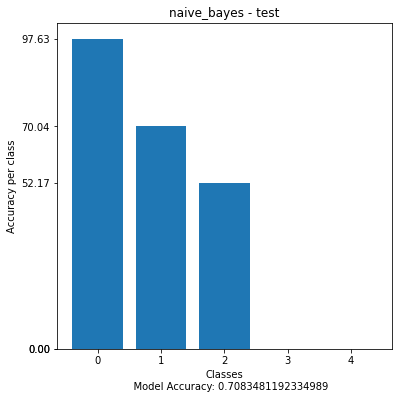

Accuracy per class: {'0': 97.63, '1': 70.04, '2': 52.17, '3': 0.0, '4': 0.0}
Confusion Matrix: 
 [[0.97631552 0.00679642 0.01688807 0.         0.        ]
 [0.28605898 0.70040214 0.01353887 0.         0.        ]
 [0.11276332 0.36555143 0.52168525 0.         0.        ]
 [0.95216638 0.00901213 0.03882149 0.         0.        ]
 [1.         0.         0.         0.         0.        ]]
MAE Test: 0.564806600425834


----------------------------------------------------------------------------------
----------------------------------------------------------------------------------
----------------------------------------------------------------------------------


Model: decision_tree
Elapsed time: 1.9471596440000667
----------------------------------------------------------------------------------

****** TEST ******
Accuracy: 0.7425479063165366


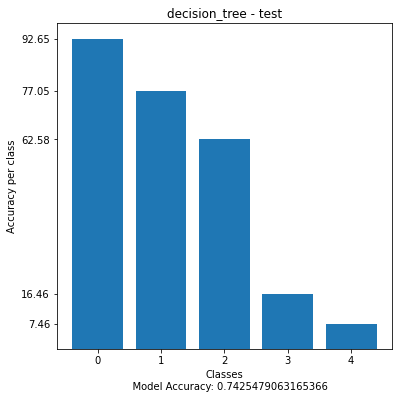

Accuracy per class: {'0': 92.65, '1': 77.05, '2': 62.58, '3': 16.46, '4': 7.46}
Confusion Matrix: 
 [[9.26475131e-01 1.08124807e-02 6.20945320e-02 5.14880033e-04
  1.02976007e-04]
 [1.81903485e-01 7.70509383e-01 9.51742627e-03 3.80697051e-02
  0.00000000e+00]
 [1.34655101e-01 2.39157373e-01 6.25774473e-01 4.13052458e-04
  0.00000000e+00]
 [7.03292894e-01 1.03986135e-03 1.29289428e-01 1.64644714e-01
  1.73310225e-03]
 [8.50746269e-01 2.98507463e-02 0.00000000e+00 4.47761194e-02
  7.46268657e-02]]
MAE Test: 0.4997338537970192


----------------------------------------------------------------------------------
----------------------------------------------------------------------------------
----------------------------------------------------------------------------------


Model: svm
Elapsed time: 175.72663348999993
----------------------------------------------------------------------------------

****** TEST ******
Accuracy: 0.7730660042583393


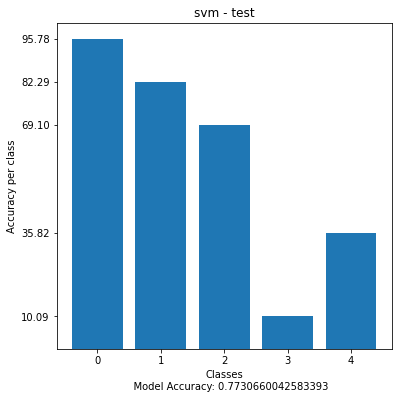

Accuracy per class: {'0': 95.78, '1': 82.29, '2': 69.1, '3': 10.09, '4': 35.82}
Confusion Matrix: 
 [[9.57779837e-01 6.69344043e-03 3.44969622e-02 4.11904026e-04
  6.17856040e-04]
 [1.75469169e-01 8.22922252e-01 1.60857909e-03 0.00000000e+00
  0.00000000e+00]
 [2.64353573e-01 4.46096654e-02 6.91036762e-01 0.00000000e+00
  0.00000000e+00]
 [8.95320624e-01 0.00000000e+00 2.07972270e-03 1.00866551e-01
  1.73310225e-03]
 [5.82089552e-01 0.00000000e+00 0.00000000e+00 5.97014925e-02
  3.58208955e-01]]
MAE Test: 0.5056777856635912


----------------------------------------------------------------------------------
----------------------------------------------------------------------------------
----------------------------------------------------------------------------------


TOTAL TIME: 319.37478760499994


In [33]:
models = {
    'logistic_regression' : LogisticRegression(max_iter = 1500, solver='liblinear'),
    'random-forest' : RandomForestClassifier(),
    'naive_bayes' : ComplementNB(),
    'decision_tree' : tree.DecisionTreeClassifier(),
    'svm' : svm.SVC(kernel='linear')
}


global_start = time.perf_counter()
for name, model in models.items():
    start = time.perf_counter()
    model.fit(X_train, y_train)
    elapsed = time.perf_counter() - start

    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    train_acc = accuracy_score(y_train, y_train_pred)
    test_acc = accuracy_score(y_test, y_test_pred)

    mae_train = mean_absolute_error(y_train, y_train_pred)
    mae_test = mean_absolute_error(y_test, y_test_pred)
    
    with open(f'{name}.pk','wb') as f:
        pickle.dump(model, f)
    
    
    

    
    print(f'Model: {name}')
    print(f'Elapsed time: {elapsed}')
    print('----------------------------------------------------------------------------------\n')
    print('****** TEST ******')
    print(f"Accuracy: {test_acc}")
    print(f"Accuracy per class: {get_accuracy_per_class(model_name=name, dataset_type='test', y_test=y_test, predictions=y_test_pred,model_accuracy=test_acc)}")
    print(f"Confusion Matrix: \n {confusion_matrix(y_test, y_test_pred, normalize='true')}")
    print(f"MAE Test: {mae_test}")
    print('\n\n----------------------------------------------------------------------------------')
    print('----------------------------------------------------------------------------------')
    print('----------------------------------------------------------------------------------\n\n')
    
total_elapsed_time = time.perf_counter() - global_start
print(f'TOTAL TIME: {total_elapsed_time}')

<h1> DEEP LEARNING

<h2> FEED FORWARD

Epoch 1/100
419/419 [==============================] - 3s 5ms/step - loss: 0.3813 - acc: 0.8974 - mse: 0.7282 - val_loss: 0.0518 - val_acc: 0.9822 - val_mse: 0.7714
Epoch 2/100
419/419 [==============================] - 1s 3ms/step - loss: 0.0457 - acc: 0.9845 - mse: 0.7746 - val_loss: 0.0354 - val_acc: 0.9877 - val_mse: 0.7741
Epoch 3/100
419/419 [==============================] - 1s 3ms/step - loss: 0.0330 - acc: 0.9887 - mse: 0.7782 - val_loss: 0.0363 - val_acc: 0.9896 - val_mse: 0.7724
Epoch 4/100
419/419 [==============================] - 1s 3ms/step - loss: 0.0271 - acc: 0.9907 - mse: 0.7827 - val_loss: 0.0232 - val_acc: 0.9924 - val_mse: 0.7758
Epoch 5/100
419/419 [==============================] - 1s 3ms/step - loss: 0.0226 - acc: 0.9930 - mse: 0.7793 - val_loss: 0.0207 - val_acc: 0.9935 - val_mse: 0.7758
Epoch 6/100
419/419 [==============================] - 1s 3ms/step - loss: 0.0193 - acc: 0.9938 - mse: 0.7813 - val_loss: 0.0184 - val_acc: 0.9941 - val_mse: 0.7760
Epoch 7/10

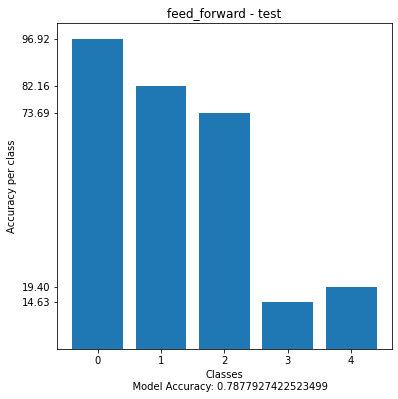

{'0': 96.92, '1': 82.16, '2': 73.69, '3': 14.63, '4': 19.4}


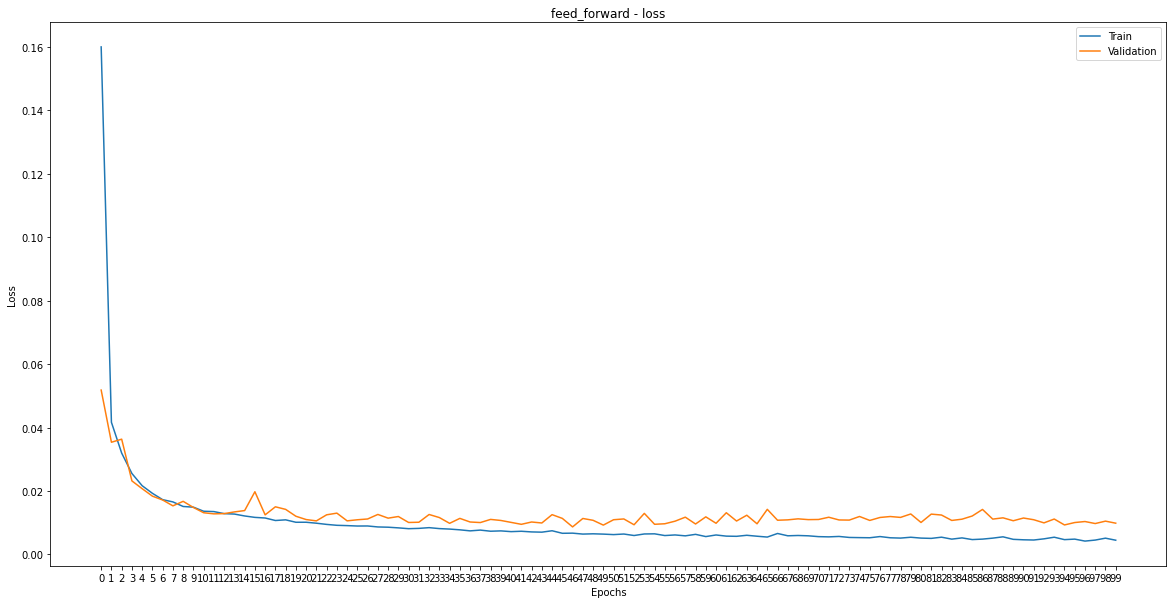

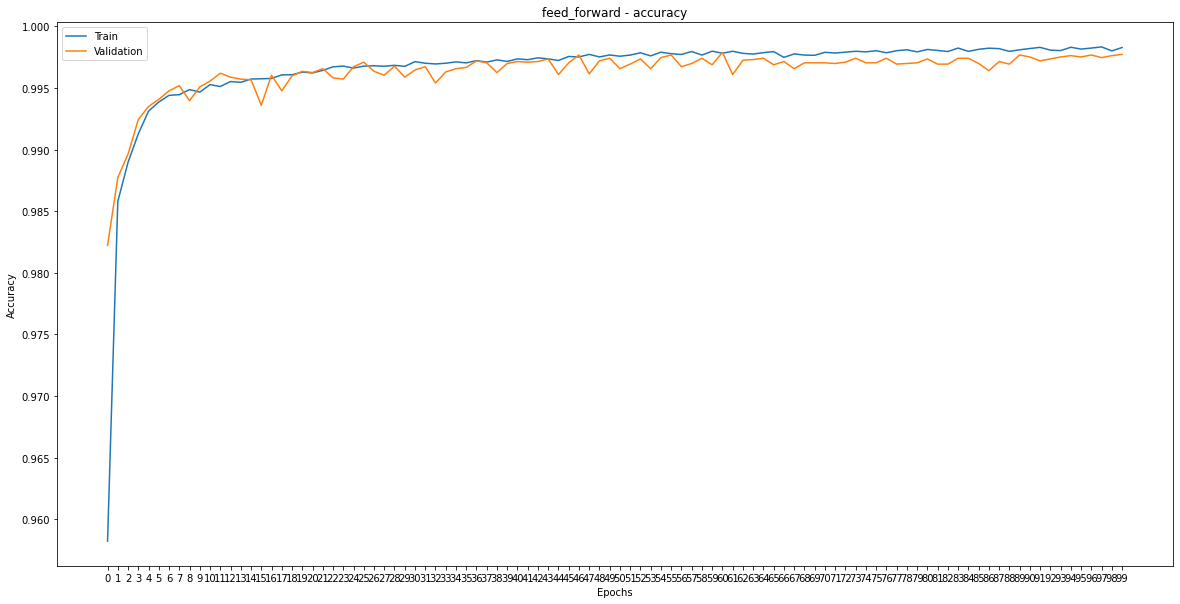

In [34]:
## FEED FORWARD

model_name = 'feed_forward'

CLASSES = 5
EPOCHS = 100
BATCH_SIZE = 256

shape = X_train.shape

model = tf.keras.Sequential()
model.add(tf.keras.layers.InputLayer(input_shape = shape))
model.add(tf.keras.layers.Dense(100, activation='relu'))
model.add(tf.keras.layers.Dense(50, activation='relu'))
model.add(tf.keras.layers.Dense(25, activation='relu'))
model.add(tf.keras.layers.Dense(CLASSES))
model.add(tf.keras.layers.Softmax())


model.compile(loss = 'sparse_categorical_crossentropy', 
              optimizer = "adam",
              metrics = ['acc','mse']
             )

tf.keras.utils.plot_model(model, f'{model_name}_graph.png', rankdir='LR')


start = time.perf_counter()
hist = model.fit(X_train, y_train, 
                 epochs=EPOCHS, 
                 # validation_data=(X_test,y_test),
                 validation_split = .15,
                 batch_size = 256,
                 shuffle = True
                )
elapsed = time.perf_counter() - start



model.save(f'{model_name}.h5')

test_loss, test_accuracy, test_mse = model.evaluate(X_test,  y_test, verbose=2)
train_loss, train_accuracy, train_mse = model.evaluate(X_train,  y_train, verbose=2)

print('Elapsed %.3f seconds.' % elapsed)
print('****** TEST ******')
print(f"Loss: {test_loss}\nAccuracy: {test_accuracy}")
print('\n')
print('****** TRAIN ******')
print(f"Loss: {train_loss}\nAccuracy: {train_accuracy}")


y_pred = model.predict([X_test])
predictions = y_pred.argmax(axis=-1)


print(get_accuracy_per_class(model_name=model_name, dataset_type='test', y_test=y_test, predictions=predictions, model_accuracy=test_accuracy))

plt.figure(figsize = (20,10))
plt.plot(hist.history['loss'], label = 'Train')
plt.plot(hist.history['val_loss'], label='Validation')
plt.title("Train Loss vs Validation Loss")
plt.xlabel("Epochs")
plt.xticks([i for i in range(EPOCHS)])
plt.ylabel("Loss")
plt.legend()
plt.title(f'{model_name} - loss')
plt.savefig(f'{model_name}_loss.png')
plt.show()


plt.figure(figsize = (20,10))
plt.plot(hist.history['acc'], label = 'Train')
plt.plot(hist.history['val_acc'], label='Validation')
plt.title("Train Accuracy vs Validation Accuracy")
plt.xlabel("Epochs")
plt.xticks([i for i in range(EPOCHS)])
plt.ylabel("Accuracy")
plt.legend()
plt.title(f'{model_name} - accuracy')
plt.savefig(f'{model_name}_accuracy.png')
plt.show()

<h2> LSTM

Epoch 1/100
419/419 [==============================] - 13s 14ms/step - loss: 0.5189 - acc: 0.8616 - mse: 0.7270 - val_loss: 0.1128 - val_acc: 0.9690 - val_mse: 0.7674
Epoch 2/100
419/419 [==============================] - 6s 13ms/step - loss: 0.1139 - acc: 0.9677 - mse: 0.7787 - val_loss: 0.0875 - val_acc: 0.9744 - val_mse: 0.7695
Epoch 3/100
419/419 [==============================] - 5s 13ms/step - loss: 0.0898 - acc: 0.9740 - mse: 0.7725 - val_loss: 0.0814 - val_acc: 0.9760 - val_mse: 0.7704
Epoch 4/100
419/419 [==============================] - 6s 14ms/step - loss: 0.0819 - acc: 0.9760 - mse: 0.7782 - val_loss: 0.0651 - val_acc: 0.9816 - val_mse: 0.7709
Epoch 5/100
419/419 [==============================] - 5s 13ms/step - loss: 0.0701 - acc: 0.9782 - mse: 0.7724 - val_loss: 0.0551 - val_acc: 0.9833 - val_mse: 0.7724
Epoch 6/100
419/419 [==============================] - 6s 13ms/step - loss: 0.0565 - acc: 0.9815 - mse: 0.7856 - val_loss: 0.0521 - val_acc: 0.9839 - val_mse: 0.7715
Epo

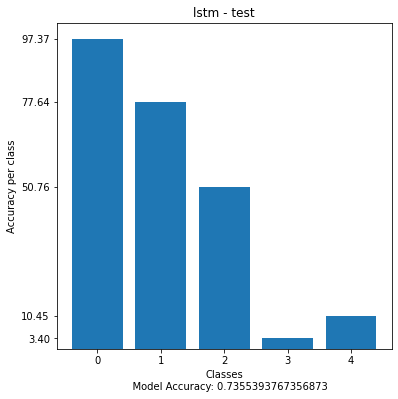

{'0': 97.37, '1': 77.64, '2': 50.76, '3': 3.4, '4': 10.45}


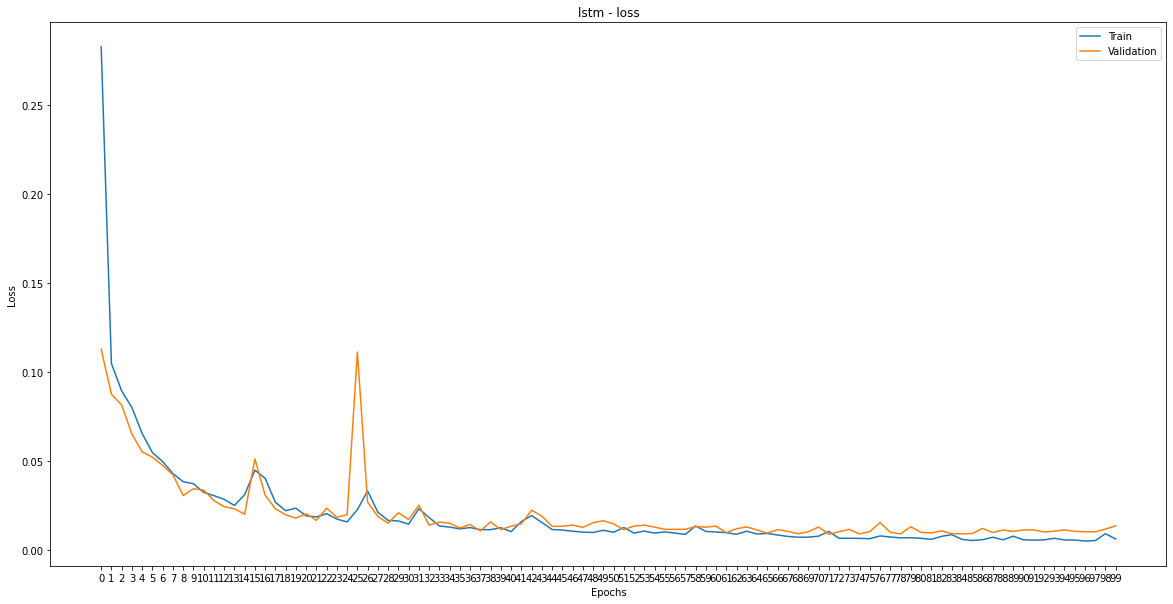

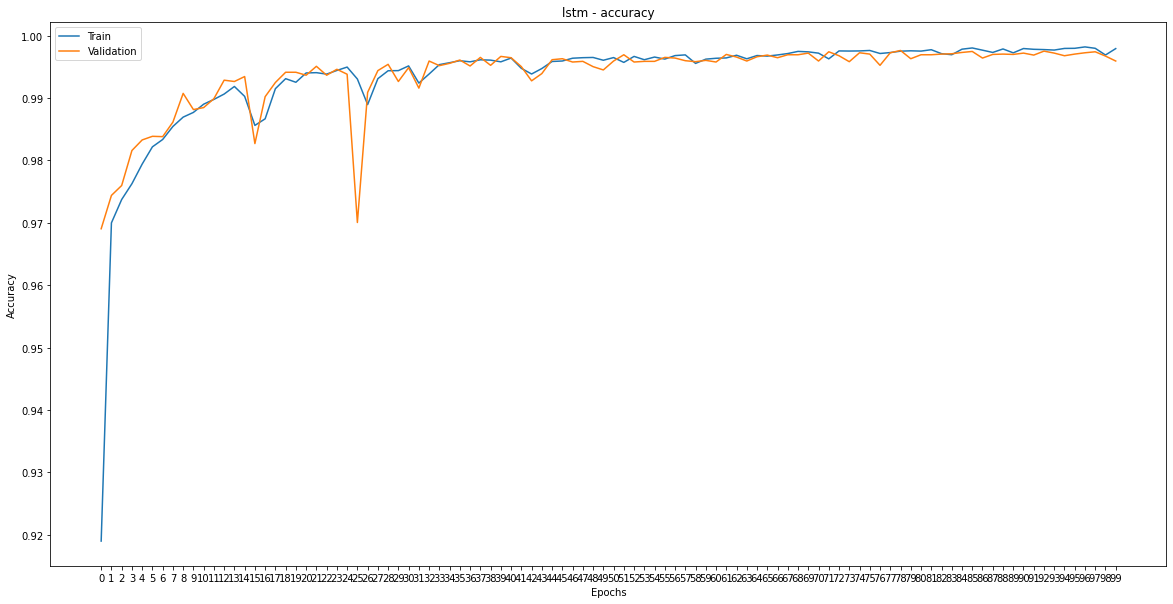

In [35]:
## LSTM

model_name = 'lstm'

CLASSES = 5
EPOCHS = 100
BATCH_SIZE = 256


X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

shape = (X_train.shape[1], X_train.shape[2])


model = tf.keras.Sequential()
model.add(tf.keras.layers.InputLayer(input_shape = shape))
model.add(tf.keras.layers.Conv1D(filters = 64, kernel_size = 4, strides = 1, padding = 'valid'))
model.add(tf.keras.layers.LSTM(80))  
model.add(tf.keras.layers.Dense(150, activation='relu'))
model.add(tf.keras.layers.Dense(CLASSES))
model.add(tf.keras.layers.Softmax())

model.compile(loss = 'sparse_categorical_crossentropy', 
              optimizer = "adam", 
              metrics = ['acc','mse']
             )

tf.keras.utils.plot_model(model, f'{model_name}_graph.png', rankdir='LR')


start = time.perf_counter()
hist = model.fit(X_train, y_train, 
                 epochs=EPOCHS, 
                 # validation_data=(X_test,y_test),
                 validation_split = .15,
                 batch_size = BATCH_SIZE,
                 shuffle = True
                )
elapsed = time.perf_counter() - start

model.save(f'{model_name}.h5')

test_loss, test_accuracy, test_mse = model.evaluate(X_test,  y_test, verbose=2)
train_loss, train_accuracy, train_mse = model.evaluate(X_train,  y_train, verbose=2)

print('Elapsed %.3f seconds.' % elapsed)
print('****** TEST ******')
print(f"Loss: {test_loss}\nAccuracy: {test_accuracy}")
print('\n')
print('****** TRAIN ******')
print(f"Loss: {train_loss}\nAccuracy: {train_accuracy}")


y_pred = model.predict([X_test])
predictions = y_pred.argmax(axis=-1)

print(get_accuracy_per_class(model_name=model_name, dataset_type='test', y_test=y_test, predictions=predictions, model_accuracy=test_accuracy))

plt.figure(figsize = (20,10))
plt.plot(hist.history['loss'], label = 'Train')
plt.plot(hist.history['val_loss'], label='Validation')
plt.title("Train Loss vs Validation Loss")
plt.xlabel("Epochs")
plt.xticks([i for i in range(EPOCHS)])
plt.ylabel("Loss")
plt.legend()
plt.title(f'{model_name} - loss')
plt.savefig(f'{model_name}_loss.png')
plt.show()


plt.figure(figsize = (20,10))
plt.plot(hist.history['acc'], label = 'Train')
plt.plot(hist.history['val_acc'], label='Validation')
plt.title("Train Accuracy vs Validation Accuracy")
plt.xlabel("Epochs")
plt.xticks([i for i in range(EPOCHS)])
plt.ylabel("Accuracy")
plt.legend()
plt.title(f'{model_name} - accuracy')
plt.savefig(f'{model_name}_accuracy.png')
plt.show()

<h2> CNN

Epoch 1/100
419/419 [==============================] - 4s 8ms/step - loss: 0.1724 - acc: 0.9491 - mse: 0.7666 - val_loss: 0.0641 - val_acc: 0.9770 - val_mse: 0.7744
Epoch 2/100
419/419 [==============================] - 3s 7ms/step - loss: 0.0564 - acc: 0.9813 - mse: 0.7809 - val_loss: 0.0344 - val_acc: 0.9912 - val_mse: 0.7739
Epoch 3/100
419/419 [==============================] - 3s 7ms/step - loss: 0.0404 - acc: 0.9876 - mse: 0.7796 - val_loss: 0.0326 - val_acc: 0.9905 - val_mse: 0.7740
Epoch 4/100
419/419 [==============================] - 3s 7ms/step - loss: 0.0331 - acc: 0.9896 - mse: 0.7787 - val_loss: 0.0253 - val_acc: 0.9925 - val_mse: 0.7755
Epoch 5/100
419/419 [==============================] - 3s 6ms/step - loss: 0.0309 - acc: 0.9904 - mse: 0.7891 - val_loss: 0.0235 - val_acc: 0.9934 - val_mse: 0.7752
Epoch 6/100
419/419 [==============================] - 3s 6ms/step - loss: 0.0273 - acc: 0.9915 - mse: 0.7789 - val_loss: 0.0213 - val_acc: 0.9938 - val_mse: 0.7755
Epoch 7/10

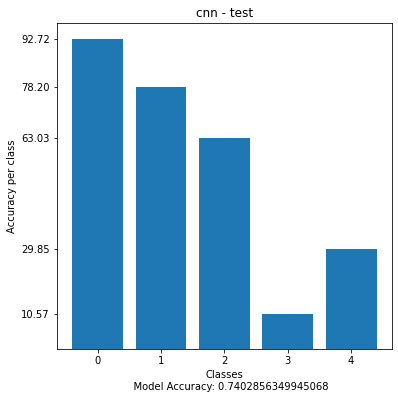

{'0': 92.72, '1': 78.2, '2': 63.03, '3': 10.57, '4': 29.85}


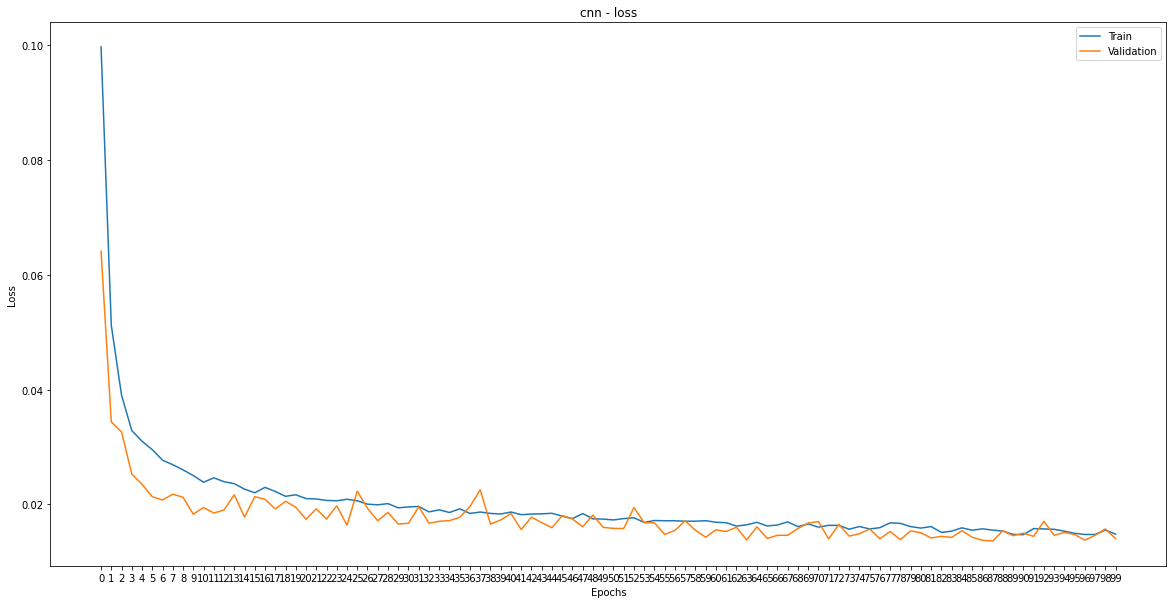

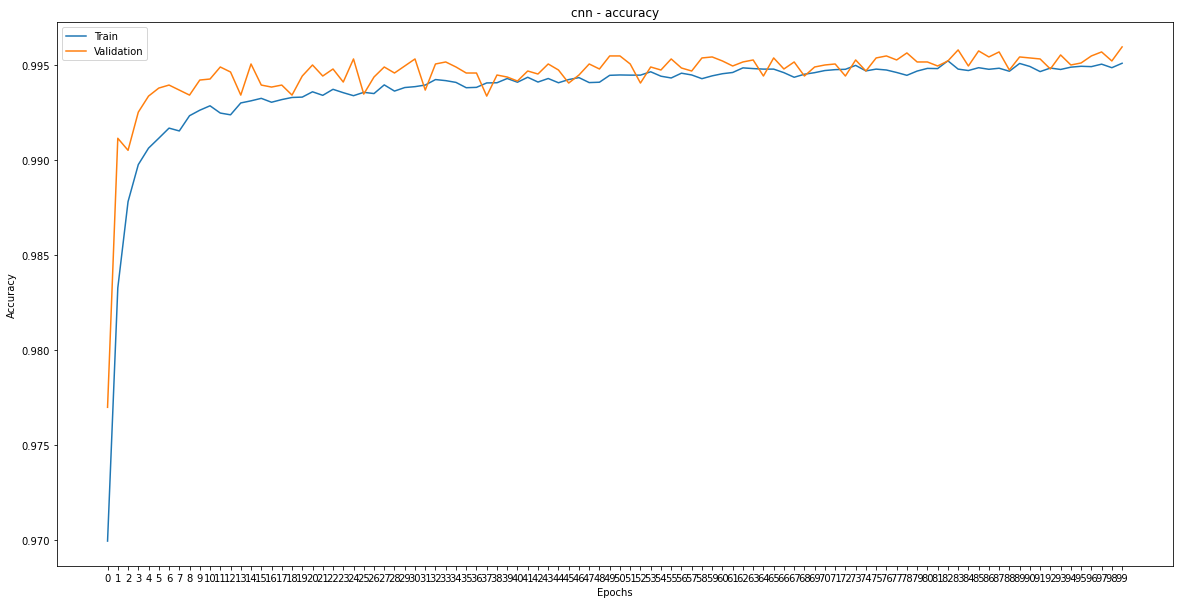

In [36]:
## CNN

model_name = 'cnn'

CLASSES = 5
EPOCHS = 100
BATCH_SIZE = 256


X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

shape = (X_train.shape[1], X_train.shape[2])


model = tf.keras.Sequential()
model.add(tf.keras.layers.Conv1D(filters = 64, kernel_size = 2, strides = 1, padding = 'valid', input_shape = shape))
model.add(tf.keras.layers.MaxPooling1D(pool_size = 2, strides = 1))
model.add(tf.keras.layers.Conv1D(filters = 64, kernel_size = 4, strides = 1, padding = 'valid'))
model.add(tf.keras.layers.MaxPooling1D(pool_size = 4, strides = 1))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(100))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(CLASSES))
model.add(tf.keras.layers.Softmax())

sgd_optimizer = tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.5)

model.compile(loss = 'sparse_categorical_crossentropy', 
              optimizer = 'adam', 
              metrics = ['acc','mse']
             )

tf.keras.utils.plot_model(model, f'{model_name}_graph.png', rankdir='LR')


start = time.perf_counter()
hist = model.fit(X_train, y_train, 
                 epochs=EPOCHS, 
                 # validation_data=(X_test,y_test),
                 validation_split = .15,
                 shuffle = True,
                 batch_size = BATCH_SIZE,
                )
elapsed = time.perf_counter() - start

model.save(f'{model_name}.h5')

test_loss, test_accuracy, test_mse = model.evaluate(X_test,  y_test, verbose=2)
train_loss, train_accuracy, train_mse = model.evaluate(X_train,  y_train, verbose=2)

print('Elapsed %.3f seconds.' % elapsed)
print('****** TEST ******')
print(f"Loss: {test_loss}\nAccuracy: {test_accuracy}")
print('\n')
print('****** TRAIN ******')
print(f"Loss: {train_loss}\nAccuracy: {train_accuracy}")


y_pred = model.predict([X_test])
predictions = y_pred.argmax(axis=-1)

print(get_accuracy_per_class(model_name=model_name, dataset_type='test', y_test=y_test, predictions=predictions, model_accuracy=test_accuracy))

plt.figure(figsize = (20,10))
plt.plot(hist.history['loss'], label = 'Train')
plt.plot(hist.history['val_loss'], label='Validation')
plt.title("Train Loss vs Validation Loss")
plt.xlabel("Epochs")
plt.xticks([i for i in range(EPOCHS)])
plt.ylabel("Loss")
plt.legend()
plt.title(f'{model_name} - loss')
plt.savefig(f'{model_name}_loss.png')
plt.show()


plt.figure(figsize = (20,10))
plt.plot(hist.history['acc'], label = 'Train')
plt.plot(hist.history['val_acc'], label='Validation')
plt.title("Train Accuracy vs Validation Accuracy")
plt.xlabel("Epochs")
plt.xticks([i for i in range(EPOCHS)])
plt.ylabel("Accuracy")
plt.legend()
plt.title(f'{model_name} - accuracy')
plt.savefig(f'{model_name}_accuracy.png')
plt.show()

<h1> CNN PAPER

<h2> NEW VERSION

Epoch 1/100
419/419 [==============================] - 5s 8ms/step - loss: 0.2747 - acc: 0.9313 - mse: 0.7489 - val_loss: 0.0833 - val_acc: 0.9760 - val_mse: 0.7701
Epoch 2/100
419/419 [==============================] - 3s 8ms/step - loss: 0.0845 - acc: 0.9732 - mse: 0.7745 - val_loss: 0.0670 - val_acc: 0.9795 - val_mse: 0.7717
Epoch 3/100
419/419 [==============================] - 3s 8ms/step - loss: 0.0718 - acc: 0.9765 - mse: 0.7723 - val_loss: 0.0587 - val_acc: 0.9825 - val_mse: 0.7718
Epoch 4/100
419/419 [==============================] - 3s 8ms/step - loss: 0.0645 - acc: 0.9787 - mse: 0.7675 - val_loss: 0.0536 - val_acc: 0.9821 - val_mse: 0.7717
Epoch 5/100
419/419 [==============================] - 4s 8ms/step - loss: 0.0598 - acc: 0.9797 - mse: 0.7759 - val_loss: 0.0490 - val_acc: 0.9838 - val_mse: 0.7730
Epoch 6/100
419/419 [==============================] - 3s 8ms/step - loss: 0.0554 - acc: 0.9816 - mse: 0.7777 - val_loss: 0.0454 - val_acc: 0.9852 - val_mse: 0.7732
Epoch 7/10

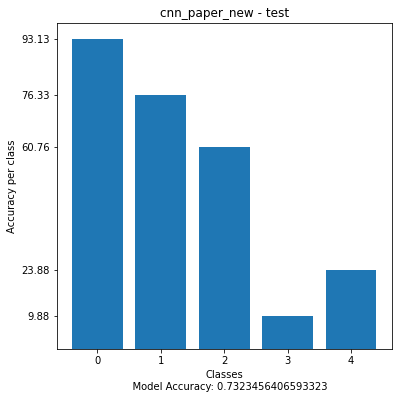

{'0': 93.13, '1': 76.33, '2': 60.76, '3': 9.88, '4': 23.88}


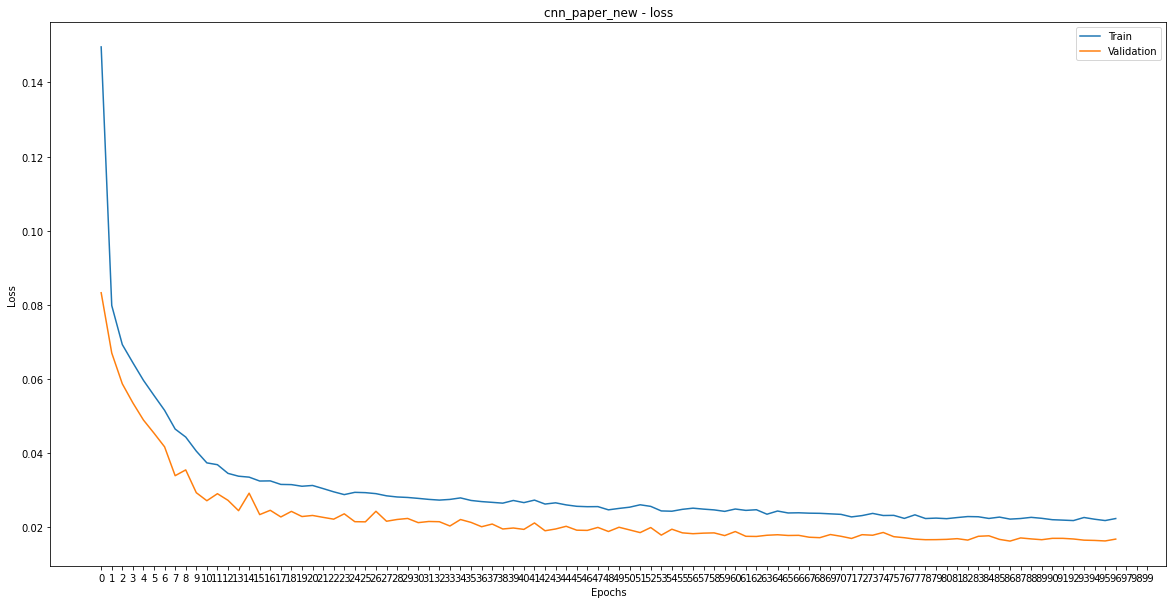

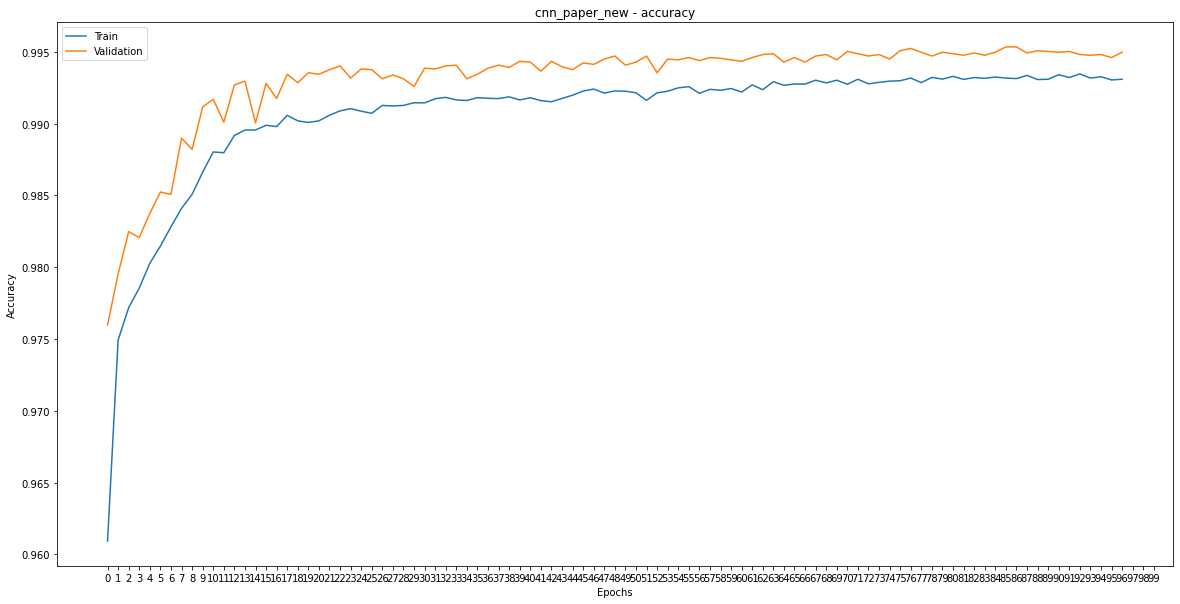

In [37]:
## CNN PAPER


model_name = 'cnn_paper_new'


CLASSES = 5
EPOCHS = 100
BATCH_SIZE = 256


X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
shape = (X_train.shape[1], X_train.shape[2])

############################ -- FIRST BLOCK -- ##########################
inp = tf.keras.layers.Input(shape)
h1=tf.keras.layers.Conv1D(filters = 32, kernel_size = 2, strides = 1)(inp)
h1=tf.keras.layers.Activation('relu')(h1)
h1=tf.keras.layers.MaxPooling1D(pool_size = 2, strides = 1)(h1)
f1=tf.keras.layers.Flatten()(h1)
out1=tf.keras.layers.Dropout(.5)(f1)
############################ -- SECOND BLOCK -- ##########################
h2=tf.keras.layers.Conv1D(filters = 32, kernel_size = 4, strides = 1)(h1)
h2=tf.keras.layers.Activation('relu')(h2)
h2=tf.keras.layers.MaxPooling1D(pool_size = 4, strides = 1)(h2)
f2=tf.keras.layers.Flatten()(h2)
out2=tf.keras.layers.Dropout(.5)(f2)
############################ -- THIRD BLOCK -- ##########################
h3=tf.keras.layers.Conv1D(filters = 32, kernel_size = 8, strides = 1)(h2)
h3=tf.keras.layers.Activation('relu')(h3)
h3=tf.keras.layers.MaxPooling1D(pool_size = 8, strides = 1)(h3)
h3=tf.keras.layers.Flatten()(h3)
h3=tf.keras.layers.Dropout(.5)(h3)
h3=tf.keras.layers.Dense(256)(h3)
h3=tf.keras.layers.Dropout(.5)(h3)
h3=tf.keras.layers.Dense(5)(h3)
out3=tf.keras.layers.Softmax()(h3)
############################ -- OUTPUT BLOCK -- ##########################
h=tf.keras.layers.concatenate([out1, out2, out3])
h=tf.keras.layers.Dense(5)(h)
R_out=tf.keras.layers.Softmax()(h)
model=tf.keras.Model(inputs=inp,outputs=R_out)


callbacks = [tf.keras.callbacks.EarlyStopping(monitor="val_loss", min_delta=0, patience=10, verbose=1, mode="auto", baseline=None, restore_best_weights=False)]
# sgd_optimizer = tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.5)
# adam_optimizer = tf.keras.optimizers.Adam(learning_rate=0.000001)

model.compile(loss = 'sparse_categorical_crossentropy', 
              optimizer = 'adam', 
              metrics = ['acc','mse'])


tf.keras.utils.plot_model(model, f'{model_name}_graph_(vertical).png')
tf.keras.utils.plot_model(model, f'{model_name}_graph_(horizontal).png', rankdir='LR')


start = time.perf_counter()
hist = model.fit(X_train, y_train, 
                 epochs=EPOCHS, 
                 # validation_data=(X_test,y_test),
                 validation_split = .15,
                 batch_size = BATCH_SIZE,
                 shuffle = True,
                 callbacks = callbacks
                )
elapsed = time.perf_counter() - start

model.save(f'{model_name}.h5')



test_loss, test_accuracy, test_mse = model.evaluate(X_test,  y_test, verbose=2)
train_loss, train_accuracy, train_mse = model.evaluate(X_train,  y_train, verbose=2)

print('Elapsed %.3f seconds.' % elapsed)
print('****** TEST ******')
print(f"Loss: {test_loss}\nAccuracy: {test_accuracy}")
print('\n')
print('****** TRAIN ******')
print(f"Loss: {train_loss}\nAccuracy: {train_accuracy}")

y_pred = model.predict([X_test])
predictions = y_pred.argmax(axis=-1)

print(get_accuracy_per_class(model_name=model_name, dataset_type='test', y_test=y_test, predictions=predictions, model_accuracy=test_accuracy))

plt.figure(figsize = (20,10))
plt.plot(hist.history['loss'], label = 'Train')
plt.plot(hist.history['val_loss'], label='Validation')
plt.title("Train Loss vs Validation Loss")
plt.xlabel("Epochs")
plt.xticks([i for i in range(EPOCHS)])
plt.ylabel("Loss")
plt.legend()
plt.title(f'{model_name} - loss')
plt.savefig(f'{model_name}_loss.png')
plt.show()


plt.figure(figsize = (20,10))
plt.plot(hist.history['acc'], label = 'Train')
plt.plot(hist.history['val_acc'], label='Validation')
plt.title("Train Accuracy vs Validation Accuracy")
plt.xlabel("Epochs")
plt.xticks([i for i in range(EPOCHS)])
plt.ylabel("Accuracy")
plt.legend()
plt.title(f'{model_name} - accuracy')
plt.savefig(f'{model_name}_accuracy.png')
plt.show()

<h2> MORE EPOCHS, LOW LR

Epoch 1/200
419/419 [==============================] - 4s 9ms/step - loss: 1.5651 - acc: 0.3558 - mse: 0.6209 - val_loss: 1.5055 - val_acc: 0.7298 - val_mse: 0.6187
Epoch 2/200
419/419 [==============================] - 3s 7ms/step - loss: 1.4898 - acc: 0.5986 - mse: 0.6289 - val_loss: 1.4305 - val_acc: 0.7610 - val_mse: 0.6192
Epoch 3/200
419/419 [==============================] - 3s 8ms/step - loss: 1.4148 - acc: 0.7251 - mse: 0.6227 - val_loss: 1.3562 - val_acc: 0.7968 - val_mse: 0.6200
Epoch 4/200
419/419 [==============================] - 3s 8ms/step - loss: 1.3408 - acc: 0.7792 - mse: 0.6252 - val_loss: 1.2822 - val_acc: 0.8292 - val_mse: 0.6213
Epoch 5/200
419/419 [==============================] - 3s 8ms/step - loss: 1.2679 - acc: 0.8088 - mse: 0.6299 - val_loss: 1.2083 - val_acc: 0.8392 - val_mse: 0.6231
Epoch 6/200
419/419 [==============================] - 3s 8ms/step - loss: 1.1940 - acc: 0.8236 - mse: 0.6297 - val_loss: 1.1359 - val_acc: 0.8427 - val_mse: 0.6254
Epoch 7/20

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


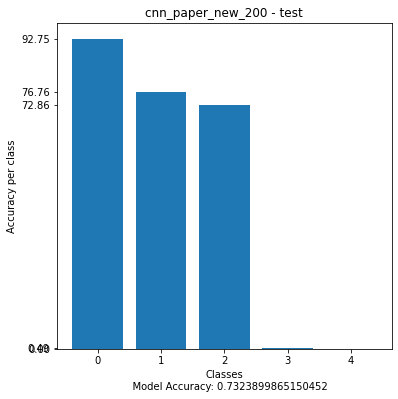

{'0': 92.75, '1': 76.76, '2': 72.86, '3': 0.49, '4': 0.0}


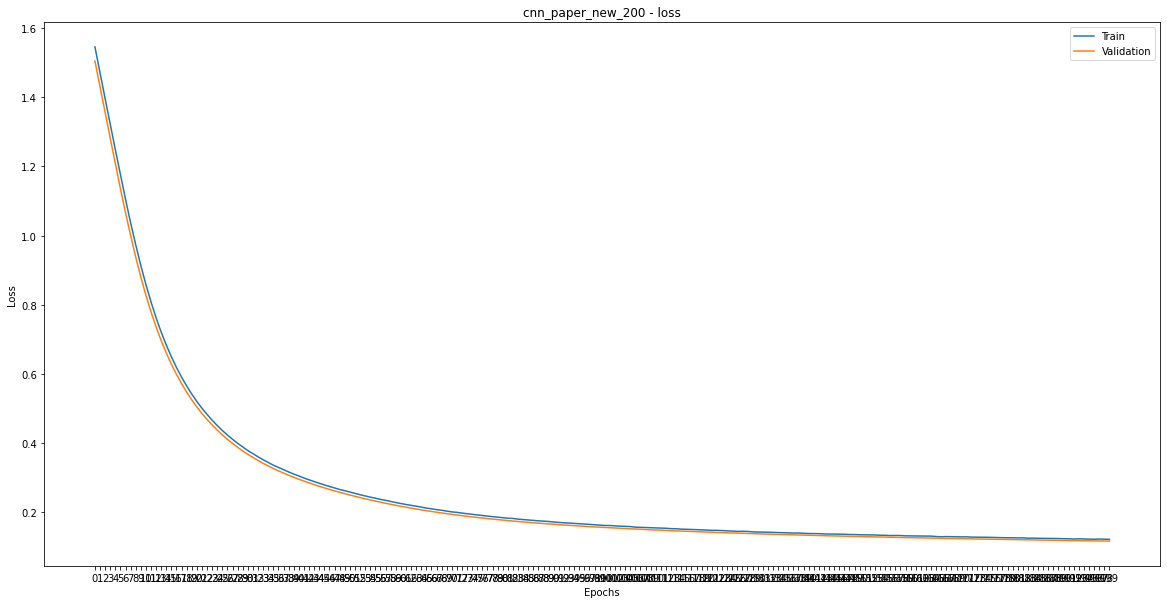

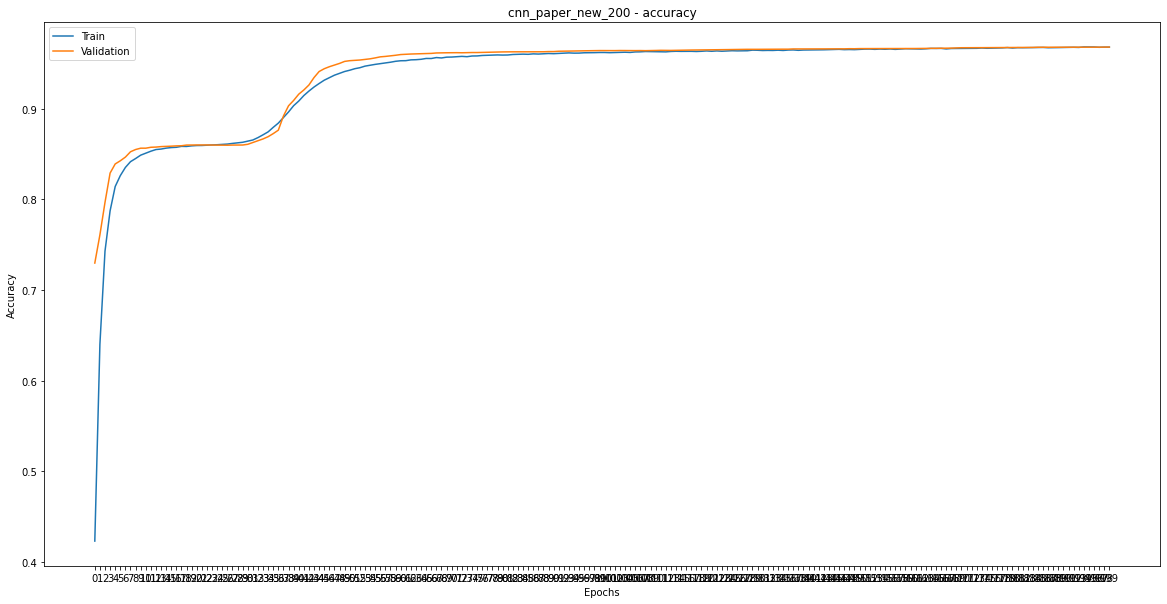

In [39]:
## CNN PAPER


model_name = 'cnn_paper_new_200'


CLASSES = 5
EPOCHS = 200
BATCH_SIZE = 256


X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
shape = (X_train.shape[1], X_train.shape[2])

############################ -- FIRST BLOCK -- ##########################
inp = tf.keras.layers.Input(shape)
h1=tf.keras.layers.Conv1D(filters = 32, kernel_size = 2, strides = 1)(inp)
h1=tf.keras.layers.Activation('relu')(h1)
h1=tf.keras.layers.MaxPooling1D(pool_size = 2, strides = 1)(h1)
f1=tf.keras.layers.Flatten()(h1)
out1=tf.keras.layers.Dropout(.5)(f1)
############################ -- SECOND BLOCK -- ##########################
h2=tf.keras.layers.Conv1D(filters = 32, kernel_size = 4, strides = 1)(h1)
h2=tf.keras.layers.Activation('relu')(h2)
h2=tf.keras.layers.MaxPooling1D(pool_size = 4, strides = 1)(h2)
f2=tf.keras.layers.Flatten()(h2)
out2=tf.keras.layers.Dropout(.5)(f2)
############################ -- THIRD BLOCK -- ##########################
h3=tf.keras.layers.Conv1D(filters = 32, kernel_size = 8, strides = 1)(h2)
h3=tf.keras.layers.Activation('relu')(h3)
h3=tf.keras.layers.MaxPooling1D(pool_size = 8, strides = 1)(h3)
h3=tf.keras.layers.Flatten()(h3)
h3=tf.keras.layers.Dropout(.5)(h3)
h3=tf.keras.layers.Dense(256)(h3)
h3=tf.keras.layers.Dropout(.5)(h3)
h3=tf.keras.layers.Dense(5)(h3)
out3=tf.keras.layers.Softmax()(h3)
############################ -- OUTPUT BLOCK -- ##########################
h=tf.keras.layers.concatenate([out1, out2, out3])
h=tf.keras.layers.Dense(5)(h)
R_out=tf.keras.layers.Softmax()(h)
model=tf.keras.Model(inputs=inp,outputs=R_out)


callbacks = [tf.keras.callbacks.EarlyStopping(monitor="val_loss", min_delta=0, patience=10, verbose=1, mode="auto", baseline=None, restore_best_weights=False)]
# sgd_optimizer = tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.5)
adam_optimizer = tf.keras.optimizers.Adam(learning_rate=0.000001)

model.compile(loss = 'sparse_categorical_crossentropy', 
              optimizer = adam_optimizer, 
              metrics = ['acc','mse'])

tf.keras.utils.plot_model(model, f'{model_name}_graph_(vertical).png')
tf.keras.utils.plot_model(model, f'{model_name}_graph_(horizontal).png', rankdir='LR')


start = time.perf_counter()
hist = model.fit(X_train, y_train, 
                 epochs=EPOCHS, 
                 # validation_data=(X_test,y_test),
                 validation_split = .15,
                 batch_size = BATCH_SIZE,
                 shuffle = True,
                 callbacks = callbacks
                )
elapsed = time.perf_counter() - start

model.save(f'{model_name}.h5')



test_loss, test_accuracy, test_mse = model.evaluate(X_test,  y_test, verbose=2)
train_loss, train_accuracy, train_mse = model.evaluate(X_train,  y_train, verbose=2)

print('Elapsed %.3f seconds.' % elapsed)
print('****** TEST ******')
print(f"Loss: {test_loss}\nAccuracy: {test_accuracy}")
print('\n')
print('****** TRAIN ******')
print(f"Loss: {train_loss}\nAccuracy: {train_accuracy}")

y_pred = model.predict([X_test])
predictions = y_pred.argmax(axis=-1)

print(get_accuracy_per_class(model_name=model_name, dataset_type='test', y_test=y_test, predictions=predictions, model_accuracy=test_accuracy))

plt.figure(figsize = (20,10))
plt.plot(hist.history['loss'], label = 'Train')
plt.plot(hist.history['val_loss'], label='Validation')
plt.title("Train Loss vs Validation Loss")
plt.xlabel("Epochs")
plt.xticks([i for i in range(EPOCHS)])
plt.ylabel("Loss")
plt.legend()
plt.title(f'{model_name} - loss')
plt.savefig(f'{model_name}_loss.png')
plt.show()


plt.figure(figsize = (20,10))
plt.plot(hist.history['acc'], label = 'Train')
plt.plot(hist.history['val_acc'], label='Validation')
plt.title("Train Accuracy vs Validation Accuracy")
plt.xlabel("Epochs")
plt.xticks([i for i in range(EPOCHS)])
plt.ylabel("Accuracy")
plt.legend()
plt.title(f'{model_name} - accuracy')
plt.savefig(f'{model_name}_accuracy.png')
plt.show()

<h2> OLD VERSION

Epoch 1/100
419/419 [==============================] - 4s 8ms/step - loss: 0.2867 - acc: 0.9254 - mse: 0.7459 - val_loss: 0.0854 - val_acc: 0.9750 - val_mse: 0.7696
Epoch 2/100
419/419 [==============================] - 3s 7ms/step - loss: 0.0828 - acc: 0.9738 - mse: 0.7669 - val_loss: 0.0674 - val_acc: 0.9790 - val_mse: 0.7707
Epoch 3/100
419/419 [==============================] - 3s 8ms/step - loss: 0.0712 - acc: 0.9766 - mse: 0.7737 - val_loss: 0.0603 - val_acc: 0.9780 - val_mse: 0.7712
Epoch 4/100
419/419 [==============================] - 3s 8ms/step - loss: 0.0645 - acc: 0.9785 - mse: 0.7705 - val_loss: 0.0549 - val_acc: 0.9820 - val_mse: 0.7724
Epoch 5/100
419/419 [==============================] - 3s 8ms/step - loss: 0.0621 - acc: 0.9794 - mse: 0.7755 - val_loss: 0.0521 - val_acc: 0.9822 - val_mse: 0.7730
Epoch 6/100
419/419 [==============================] - 3s 7ms/step - loss: 0.0589 - acc: 0.9806 - mse: 0.7764 - val_loss: 0.0513 - val_acc: 0.9816 - val_mse: 0.7720
Epoch 7/10

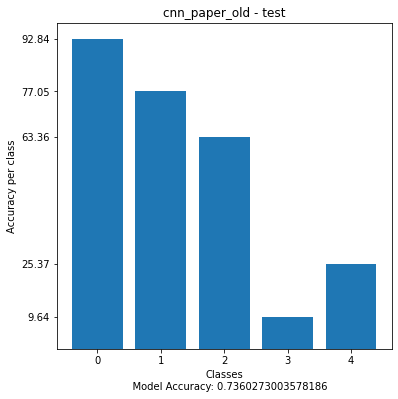

{'0': 92.84, '1': 77.05, '2': 63.36, '3': 9.64, '4': 25.37}


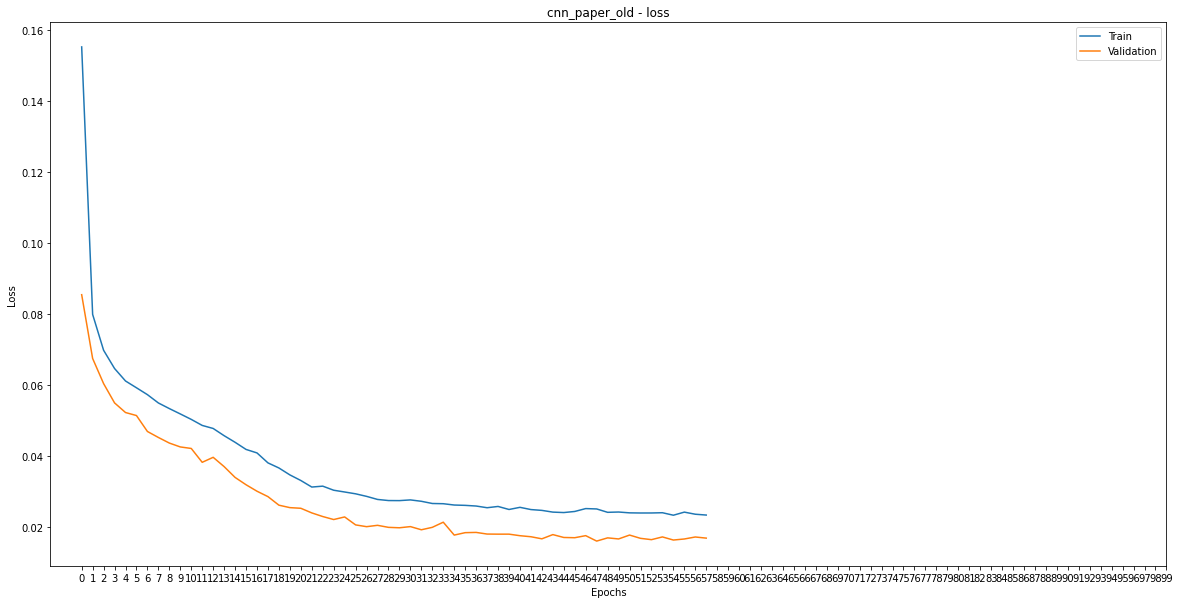

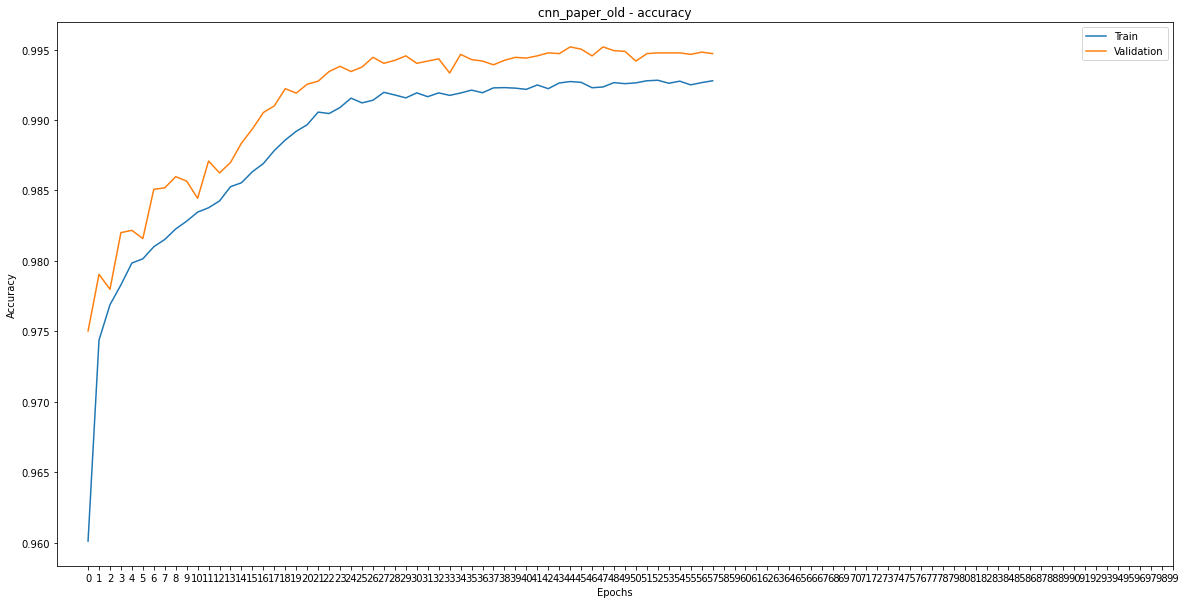

In [40]:
## CNN PAPER


model_name = 'cnn_paper_old'


CLASSES = 5
EPOCHS = 100
BATCH_SIZE = 256


X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
shape = (X_train.shape[1], X_train.shape[2])

############################ -- FIRST BLOCK -- ##########################
inp = tf.keras.layers.Input(shape)
h1=tf.keras.layers.Conv1D(filters = 32, kernel_size = 2, strides = 1)(inp)
h1=tf.keras.layers.Activation('relu')(h1)
h1=tf.keras.layers.MaxPooling1D(pool_size = 2, strides = 1)(h1)
h1=tf.keras.layers.Flatten()(h1)
out1=tf.keras.layers.Dropout(.5)(h1)
############################ -- SECOND BLOCK -- ##########################
h2=tf.keras.layers.Conv1D(filters = 32, kernel_size = 4, strides = 1)(inp)
h2=tf.keras.layers.Activation('relu')(h2)
h2=tf.keras.layers.MaxPooling1D(pool_size = 4, strides = 1)(h2)
h2=tf.keras.layers.Flatten()(h2)
out2=tf.keras.layers.Dropout(.5)(h2)
############################ -- THIRD BLOCK -- ##########################
h3=tf.keras.layers.Conv1D(filters = 32, kernel_size = 8, strides = 1)(inp)
h3=tf.keras.layers.Activation('relu')(h3)
h3=tf.keras.layers.MaxPooling1D(pool_size = 8, strides = 1)(h3)
h3=tf.keras.layers.Flatten()(h3)
h3=tf.keras.layers.Dropout(.5)(h3)
h3=tf.keras.layers.Dense(256)(h3)
h3=tf.keras.layers.Dropout(.5)(h3)
h3=tf.keras.layers.Dense(5)(h3)
out3=tf.keras.layers.Softmax()(h3)
############################ -- OUTPUT BLOCK -- ##########################
h=tf.keras.layers.concatenate([out1, out2, out3])
h=tf.keras.layers.Dense(5)(h)
R_out=tf.keras.layers.Softmax()(h)
model=tf.keras.Model(inputs=inp,outputs=R_out)


callbacks = [tf.keras.callbacks.EarlyStopping(monitor="val_loss", min_delta=0, patience=10, verbose=1, mode="auto", baseline=None, restore_best_weights=False)]
# sgd_optimizer = tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.5)
# adam_optimizer = tf.keras.optimizers.Adam(learning_rate=0.000001)

model.compile(loss = 'sparse_categorical_crossentropy', 
              optimizer = 'adam', 
              metrics = ['acc','mse'])

tf.keras.utils.plot_model(model, f'{model_name}_graph_(vertical).png')
tf.keras.utils.plot_model(model, f'{model_name}_graph_(horizontal).png', rankdir='LR')


start = time.perf_counter()
hist = model.fit(X_train, y_train, 
                 epochs=EPOCHS, 
                 # validation_data=(X_test,y_test),
                 validation_split = .15,
                 batch_size = BATCH_SIZE,
                 shuffle = True,
                 callbacks = callbacks
                )
elapsed = time.perf_counter() - start

model.save(f'{model_name}.h5')





test_loss, test_accuracy, test_mse = model.evaluate(X_test,  y_test, verbose=2)
train_loss, train_accuracy, train_mse = model.evaluate(X_train,  y_train, verbose=2)

print('Elapsed %.3f seconds.' % elapsed)
print('****** TEST ******')
print(f"Loss: {test_loss}\nAccuracy: {test_accuracy}")
print('\n')
print('****** TRAIN ******')
print(f"Loss: {train_loss}\nAccuracy: {train_accuracy}")

y_pred = model.predict([X_test])
predictions = y_pred.argmax(axis=-1)

print(get_accuracy_per_class(model_name=model_name, dataset_type='test', y_test=y_test, predictions=predictions, model_accuracy=test_accuracy))

plt.figure(figsize = (20,10))
plt.plot(hist.history['loss'], label = 'Train')
plt.plot(hist.history['val_loss'], label='Validation')
plt.title("Train Loss vs Validation Loss")
plt.xlabel("Epochs")
plt.xticks([i for i in range(EPOCHS)])
plt.ylabel("Loss")
plt.legend()
plt.title(f'{model_name} - loss')
plt.savefig(f'{model_name}_loss.png')
plt.show()


plt.figure(figsize = (20,10))
plt.plot(hist.history['acc'], label = 'Train')
plt.plot(hist.history['val_acc'], label='Validation')
plt.title("Train Accuracy vs Validation Accuracy")
plt.xlabel("Epochs")
plt.xticks([i for i in range(EPOCHS)])
plt.ylabel("Accuracy")
plt.legend()
plt.title(f'{model_name} - accuracy')
plt.savefig(f'{model_name}_accuracy.png')
plt.show()

<h2> CNN PAPER SGD + Momentum

Epoch 1/100
419/419 [==============================] - 5s 9ms/step - loss: 1.0314 - acc: 0.7610 - mse: 0.6521 - val_loss: 0.4624 - val_acc: 0.8588 - val_mse: 0.7106
Epoch 2/100
419/419 [==============================] - 3s 8ms/step - loss: 0.4330 - acc: 0.8577 - mse: 0.7232 - val_loss: 0.3477 - val_acc: 0.8586 - val_mse: 0.7282
Epoch 3/100
419/419 [==============================] - 3s 8ms/step - loss: 0.3420 - acc: 0.8756 - mse: 0.7389 - val_loss: 0.2937 - val_acc: 0.9157 - val_mse: 0.7362
Epoch 4/100
419/419 [==============================] - 3s 8ms/step - loss: 0.2907 - acc: 0.9184 - mse: 0.7444 - val_loss: 0.2577 - val_acc: 0.9390 - val_mse: 0.7414
Epoch 5/100
419/419 [==============================] - 3s 7ms/step - loss: 0.2568 - acc: 0.9374 - mse: 0.7426 - val_loss: 0.2312 - val_acc: 0.9530 - val_mse: 0.7450
Epoch 6/100
419/419 [==============================] - 3s 8ms/step - loss: 0.2343 - acc: 0.9476 - mse: 0.7521 - val_loss: 0.2110 - val_acc: 0.9578 - val_mse: 0.7481
Epoch 7/10

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


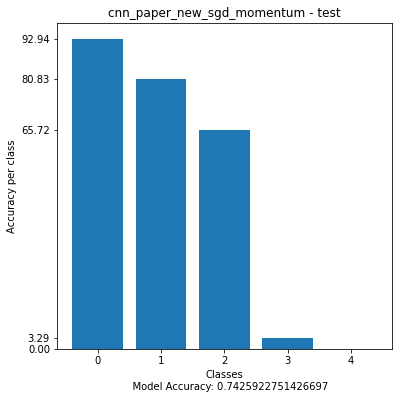

{'0': 92.94, '1': 80.83, '2': 65.72, '3': 3.29, '4': 0.0}


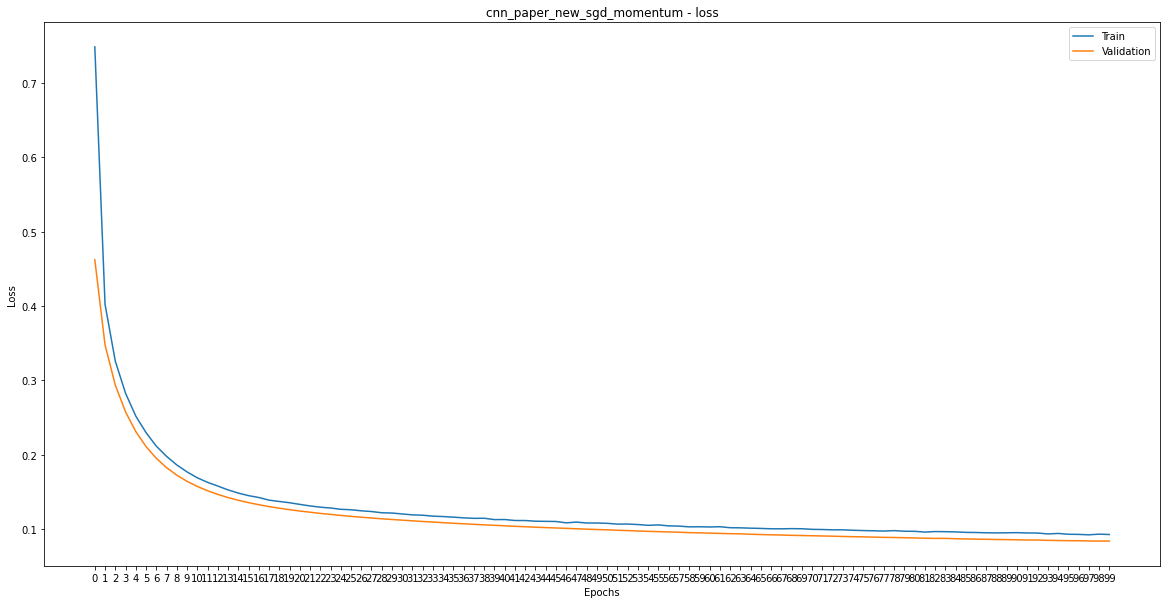

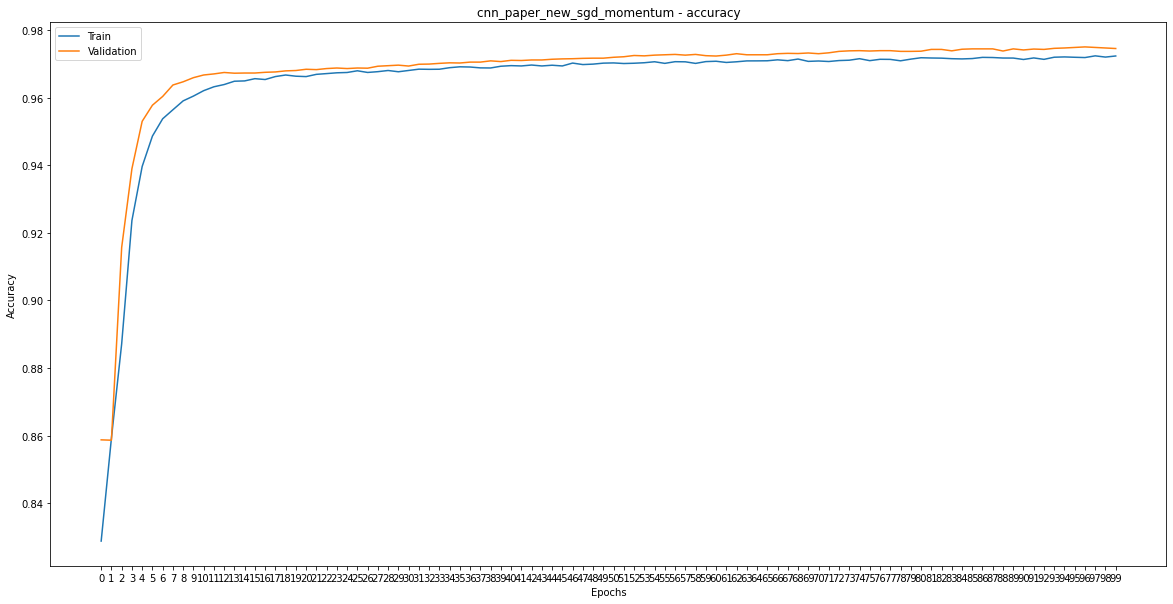

In [41]:
## CNN PAPER


model_name = 'cnn_paper_new_sgd_momentum'


CLASSES = 5
EPOCHS = 100
BATCH_SIZE = 256


X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
shape = (X_train.shape[1], X_train.shape[2])

############################ -- FIRST BLOCK -- ##########################
inp = tf.keras.layers.Input(shape)
h1=tf.keras.layers.Conv1D(filters = 32, kernel_size = 2, strides = 1)(inp)
h1=tf.keras.layers.Activation('relu')(h1)
h1=tf.keras.layers.MaxPooling1D(pool_size = 2, strides = 1)(h1)
f1=tf.keras.layers.Flatten()(h1)
out1=tf.keras.layers.Dropout(.5)(f1)
############################ -- SECOND BLOCK -- ##########################
h2=tf.keras.layers.Conv1D(filters = 32, kernel_size = 4, strides = 1)(h1)
h2=tf.keras.layers.Activation('relu')(h2)
h2=tf.keras.layers.MaxPooling1D(pool_size = 4, strides = 1)(h2)
f2=tf.keras.layers.Flatten()(h2)
out2=tf.keras.layers.Dropout(.5)(f2)
############################ -- THIRD BLOCK -- ##########################
h3=tf.keras.layers.Conv1D(filters = 32, kernel_size = 8, strides = 1)(h2)
h3=tf.keras.layers.Activation('relu')(h3)
h3=tf.keras.layers.MaxPooling1D(pool_size = 8, strides = 1)(h3)
h3=tf.keras.layers.Flatten()(h3)
h3=tf.keras.layers.Dropout(.5)(h3)
h3=tf.keras.layers.Dense(256)(h3)
h3=tf.keras.layers.Dropout(.5)(h3)
h3=tf.keras.layers.Dense(5)(h3)
out3=tf.keras.layers.Softmax()(h3)
############################ -- OUTPUT BLOCK -- ##########################
h=tf.keras.layers.concatenate([out1, out2, out3])
h=tf.keras.layers.Dense(5)(h)
R_out=tf.keras.layers.Softmax()(h)
model=tf.keras.Model(inputs=inp,outputs=R_out)


callbacks = [tf.keras.callbacks.EarlyStopping(monitor="val_loss", min_delta=0, patience=10, verbose=1, mode="auto", baseline=None, restore_best_weights=False)]
sgd_optimizer = tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.5)

model.compile(loss = 'sparse_categorical_crossentropy', 
              optimizer = sgd_optimizer, 
              metrics = ['acc','mse'])


tf.keras.utils.plot_model(model, f'{model_name}_graph_(vertical).png')
tf.keras.utils.plot_model(model, f'{model_name}_graph_(horizontal).png', rankdir='LR')


start = time.perf_counter()
hist = model.fit(X_train, y_train, 
                 epochs=EPOCHS, 
                 # validation_data=(X_test,y_test),
                 validation_split = .15,
                 batch_size = BATCH_SIZE,
                 shuffle = True,
                 callbacks = callbacks
                )
elapsed = time.perf_counter() - start

model.save(f'{model_name}.h5')



test_loss, test_accuracy, test_mse = model.evaluate(X_test,  y_test, verbose=2)
train_loss, train_accuracy, train_mse = model.evaluate(X_train,  y_train, verbose=2)

print('Elapsed %.3f seconds.' % elapsed)
print('****** TEST ******')
print(f"Loss: {test_loss}\nAccuracy: {test_accuracy}")
print('\n')
print('****** TRAIN ******')
print(f"Loss: {train_loss}\nAccuracy: {train_accuracy}")

y_pred = model.predict([X_test])
predictions = y_pred.argmax(axis=-1)

print(get_accuracy_per_class(model_name=model_name, dataset_type='test', y_test=y_test, predictions=predictions, model_accuracy=test_accuracy))

plt.figure(figsize = (20,10))
plt.plot(hist.history['loss'], label = 'Train')
plt.plot(hist.history['val_loss'], label='Validation')
plt.title("Train Loss vs Validation Loss")
plt.xlabel("Epochs")
plt.xticks([i for i in range(EPOCHS)])
plt.ylabel("Loss")
plt.legend()
plt.title(f'{model_name} - loss')
plt.savefig(f'{model_name}_loss.png')
plt.show()


plt.figure(figsize = (20,10))
plt.plot(hist.history['acc'], label = 'Train')
plt.plot(hist.history['val_acc'], label='Validation')
plt.title("Train Accuracy vs Validation Accuracy")
plt.xlabel("Epochs")
plt.xticks([i for i in range(EPOCHS)])
plt.ylabel("Accuracy")
plt.legend()
plt.title(f'{model_name} - accuracy')
plt.savefig(f'{model_name}_accuracy.png')
plt.show()

<h2> CNN PAPER L2

Epoch 1/100
419/419 [==============================] - 4s 8ms/step - loss: 0.5102 - acc: 0.9268 - mse: 0.7439 - val_loss: 0.1221 - val_acc: 0.9745 - val_mse: 0.7664
Epoch 2/100
419/419 [==============================] - 3s 8ms/step - loss: 0.1182 - acc: 0.9733 - mse: 0.7675 - val_loss: 0.1044 - val_acc: 0.9759 - val_mse: 0.7669
Epoch 3/100
419/419 [==============================] - 3s 8ms/step - loss: 0.1066 - acc: 0.9735 - mse: 0.7688 - val_loss: 0.0956 - val_acc: 0.9745 - val_mse: 0.7688
Epoch 4/100
419/419 [==============================] - 4s 8ms/step - loss: 0.1009 - acc: 0.9738 - mse: 0.7722 - val_loss: 0.0932 - val_acc: 0.9771 - val_mse: 0.7676
Epoch 5/100
419/419 [==============================] - 3s 8ms/step - loss: 0.0974 - acc: 0.9746 - mse: 0.7742 - val_loss: 0.0886 - val_acc: 0.9769 - val_mse: 0.7698
Epoch 6/100
419/419 [==============================] - 3s 8ms/step - loss: 0.0933 - acc: 0.9753 - mse: 0.7770 - val_loss: 0.0863 - val_acc: 0.9759 - val_mse: 0.7708
Epoch 7/10

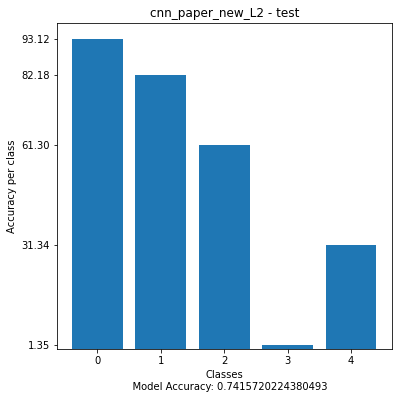

{'0': 93.12, '1': 82.18, '2': 61.3, '3': 1.35, '4': 31.34}


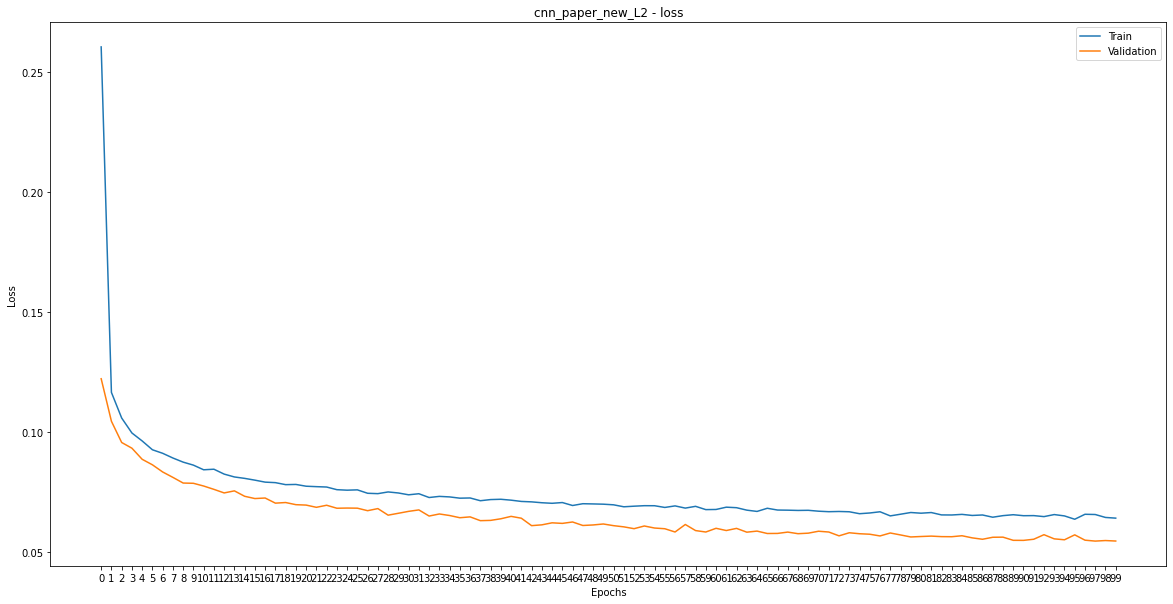

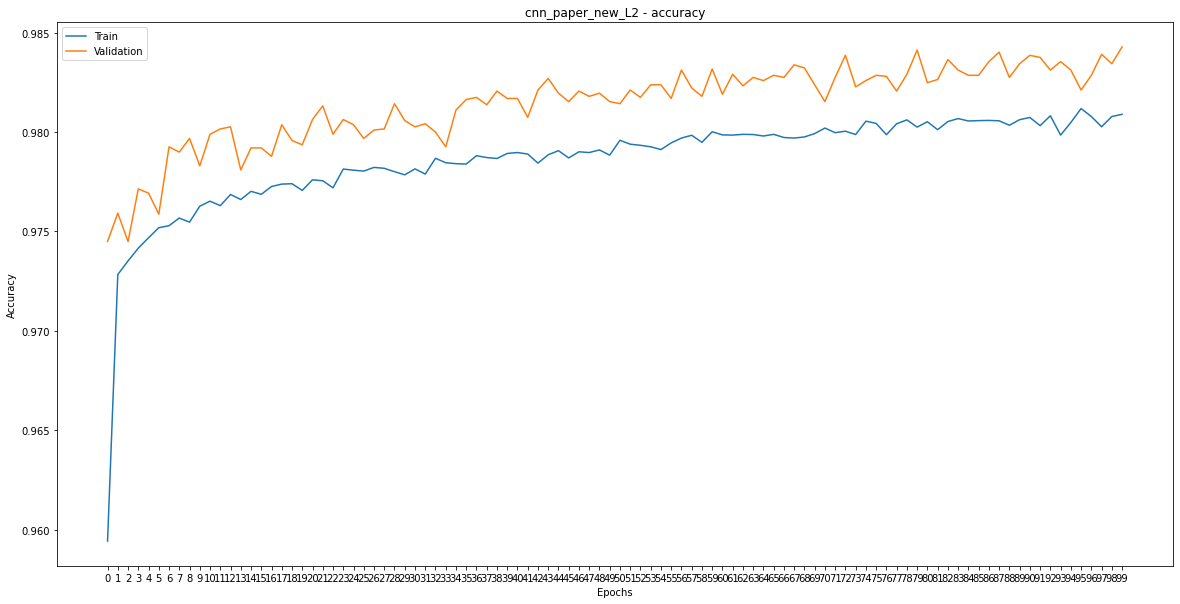

In [42]:
## CNN PAPER


model_name = 'cnn_paper_new_L2'


CLASSES = 5
EPOCHS = 100
BATCH_SIZE = 256


X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
shape = (X_train.shape[1], X_train.shape[2])

############################ -- FIRST BLOCK -- ##########################
inp = tf.keras.layers.Input(shape)
h1=tf.keras.layers.Conv1D(filters = 32, kernel_size = 2, strides = 1, kernel_regularizer = 'l2')(inp)
h1=tf.keras.layers.Activation('relu')(h1)
h1=tf.keras.layers.MaxPooling1D(pool_size = 2, strides = 1)(h1)
f1=tf.keras.layers.Flatten()(h1)
out1=tf.keras.layers.Dropout(.5)(f1)
############################ -- SECOND BLOCK -- ##########################
h2=tf.keras.layers.Conv1D(filters = 32, kernel_size = 4, strides = 1, kernel_regularizer = 'l2')(h1)
h2=tf.keras.layers.Activation('relu')(h2)
h2=tf.keras.layers.MaxPooling1D(pool_size = 4, strides = 1)(h2)
f2=tf.keras.layers.Flatten()(h2)
out2=tf.keras.layers.Dropout(.5)(f2)
############################ -- THIRD BLOCK -- ##########################
h3=tf.keras.layers.Conv1D(filters = 32, kernel_size = 8, strides = 1, kernel_regularizer = 'l2')(h2)
h3=tf.keras.layers.Activation('relu')(h3)
h3=tf.keras.layers.MaxPooling1D(pool_size = 8, strides = 1)(h3)
h3=tf.keras.layers.Flatten()(h3)
h3=tf.keras.layers.Dropout(.5)(h3)
h3=tf.keras.layers.Dense(256)(h3)
h3=tf.keras.layers.Dropout(.5)(h3)
h3=tf.keras.layers.Dense(5)(h3)
out3=tf.keras.layers.Softmax()(h3)
############################ -- OUTPUT BLOCK -- ##########################
h=tf.keras.layers.concatenate([out1, out2, out3])
h=tf.keras.layers.Dense(5)(h)
R_out=tf.keras.layers.Softmax()(h)
model=tf.keras.Model(inputs=inp,outputs=R_out)


callbacks = [tf.keras.callbacks.EarlyStopping(monitor="val_loss", min_delta=0, patience=10, verbose=1, mode="auto", baseline=None, restore_best_weights=False)]


model.compile(loss = 'sparse_categorical_crossentropy', 
              optimizer = 'adam', 
              metrics = ['acc','mse'])


tf.keras.utils.plot_model(model, f'{model_name}_graph_(vertical).png')
tf.keras.utils.plot_model(model, f'{model_name}_graph_(horizontal).png', rankdir='LR')


start = time.perf_counter()
hist = model.fit(X_train, y_train, 
                 epochs=EPOCHS, 
                 # validation_data=(X_test,y_test),
                 validation_split = .15,
                 batch_size = BATCH_SIZE,
                 shuffle = True,
                 callbacks = callbacks
                )
elapsed = time.perf_counter() - start

model.save(f'{model_name}.h5')



test_loss, test_accuracy, test_mse = model.evaluate(X_test,  y_test, verbose=2)
train_loss, train_accuracy, train_mse = model.evaluate(X_train,  y_train, verbose=2)

print('Elapsed %.3f seconds.' % elapsed)
print('****** TEST ******')
print(f"Loss: {test_loss}\nAccuracy: {test_accuracy}")
print('\n')
print('****** TRAIN ******')
print(f"Loss: {train_loss}\nAccuracy: {train_accuracy}")

y_pred = model.predict([X_test])
predictions = y_pred.argmax(axis=-1)

print(get_accuracy_per_class(model_name=model_name, dataset_type='test', y_test=y_test, predictions=predictions, model_accuracy=test_accuracy))

plt.figure(figsize = (20,10))
plt.plot(hist.history['loss'], label = 'Train')
plt.plot(hist.history['val_loss'], label='Validation')
plt.title("Train Loss vs Validation Loss")
plt.xlabel("Epochs")
plt.xticks([i for i in range(EPOCHS)])
plt.ylabel("Loss")
plt.legend()
plt.title(f'{model_name} - loss')
plt.savefig(f'{model_name}_loss.png')
plt.show()


plt.figure(figsize = (20,10))
plt.plot(hist.history['acc'], label = 'Train')
plt.plot(hist.history['val_acc'], label='Validation')
plt.title("Train Accuracy vs Validation Accuracy")
plt.xlabel("Epochs")
plt.xticks([i for i in range(EPOCHS)])
plt.ylabel("Accuracy")
plt.legend()
plt.title(f'{model_name} - accuracy')
plt.savefig(f'{model_name}_accuracy.png')
plt.show()